In [1]:
import random
import string
from datetime import datetime, timedelta
import psycopg2
from psycopg2 import sql
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.ticker as mtick  # Importa el módulo para formatear el eje
import re # Expresiones regulares
from IPython.display import display


In [2]:
# ------------ FUNCIONES ----------------

# 1. Conexión con BD
# 1.1 Con PSYCOPG2
def conexionBDPostgresSQL():
    # Se omiten los datos de conexión.
    conexion = psycopg2.connect(
        dbname="postgres",
        user="postgres",
        password="serRIB99",
        host="localhost",
        port="5432"
    )
    return conexion



# 0.
def obtenerDatosBBDD(comandoSQL):
    # Crear conexión y obtener cursor
    conexionBD = conexionBDPostgresSQL() #conexionBDPostgresSQL()
    cursor = conexionBD.cursor()

    # Ejecutar comando y obtener datos
    cursor.execute(comandoSQL)
    registros = cursor.fetchall()

    # Obtener columnas desde el cursor
    columnas = [desc[0] for desc in cursor.description]
    cursor.close()
    conexionBD.close()
    return registros, columnas


# 1. Obtener datos emisiones (procesados)
def obtenerDataFrameclimatologia():
  comandoSQL_climatologia = "SELECT * FROM tfm.climatologia_procesada ORDER BY \"fecha\" ASC"
  datosclimatologia, columnasclimatologia =  obtenerDatosBBDD(comandoSQL_climatologia)
  df_climatologia = pd.DataFrame(datosclimatologia, columns=columnasclimatologia)
  return df_climatologia


def crearColumnasAnyoMesDia(dataset):
  # Crear nuevas columnas
  dataset['Año'] = dataset['fecha'].dt.year
  dataset['Mes'] = dataset['fecha'].dt.month
  dataset['Dia'] = dataset['fecha'].dt.day
  dataset['DiaSemana'] = dataset['fecha'].dt.weekday + 1  # +1 para que 1=Lunes, ..., 7=Domingo
  return dataset





def generarGraficasDistribucion_2filas_gen(dataset,fecha,mes,dia_semana,columna):

    diccionarioMeses = {
        1: 'Enero',
        2: 'Febrero',
        3: 'Marzo',
        4: 'Abril',
        5: 'Mayo',
        6: 'Junio',
        7: 'Julio',
        8: 'Agosto',
        9: 'Septiembre',
        10: 'Octubre',
        11: 'Noviembre',
        12: 'Diciembre'
    }
    diccionarioDiaSemana = {
        1: 'Lunes',
        2: 'Martes',
        3: 'Miércoles',
        4: 'Jueves',
        5: 'Viernes',
        6: 'Sábado',
        7: 'Domingo'
    }
    # Ajustar tamaño de la figura para 1 fila de 3 gráficos y 1 fila de 1 gráfico que ocupe todo el ancho
    fig = plt.figure(figsize=(15, 10), dpi=300)
    # Crear subplots manualmente
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
    ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
    ax3 = plt.subplot2grid((3, 3), (0, 2), colspan=1)
    ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=3, rowspan=1)  # Este eje ocupa toda la segunda fila
    
    # climatologia por día de la semana
    
    # Agrupar los datos por la columna especificada y calcular la media de los valores en esos grupos
    df_agrupado_dia = dataset.groupby(dia_semana)[columna].mean().reset_index()

    # Calcular la media global de la columna agrupada (después de agrupar)
    media_global = df_agrupado_dia[columna].mean()
    
    etiquetas_traducidas_dia = [diccionarioDiaSemana.get(label, label) for label in df_agrupado_dia[dia_semana]]

    # Crear el gráfico de barras
    bar_positions = range(len(df_agrupado_dia[columna]))
    ax1.bar(bar_positions, df_agrupado_dia[columna], color='lightcoral')

    # Añadir la línea de la media global de los valores agrupados
    ax1.axhline(y=media_global, color='red', linestyle='--', label=f'Valor medio: ({media_global:.2f})')
    # Reducir el tamaño de la leyenda
    ax1.legend(loc='upper right', framealpha=0.5, fontsize='small')


    # Añadir etiquetas y título
    #ax1.xlabel(columna_para_agrupar.capitalize())
    #ax1.ylabel('Valor emisiones media')
    ax1.set_title(f'clima por día de la semana de: {columna.upper()}')

    # Configurar xticks manualmente para mostrar todas las etiquetas correctamente alineadas
    ax1.set_xticks(ticks=bar_positions, labels=etiquetas_traducidas_dia, rotation=45, ha='right')

    # clima por mes
    
    # Agrupar los datos por la columna especificada y calcular la media de los valores en esos grupos
    df_agrupado_mes = dataset.groupby(mes)[columna].mean().reset_index()

    # Calcular la media global de la columna agrupada (después de agrupar)
    media_global = df_agrupado_mes[columna].mean()

    # Crear el gráfico de barras
    bar_positions = range(len(df_agrupado_mes[columna]))
    ax2.bar(bar_positions, df_agrupado_mes[columna], color='khaki')

    # Añadir la línea de la media global de los valores agrupados
    ax2.axhline(y=media_global, color='red', linestyle='--', label=f'Valor medio: ({media_global:.2f})')
    # Reducir el tamaño de la leyenda
    ax2.legend(loc='upper right', framealpha=0.5, fontsize='small')

    etiquetas_traducidas_mes = [diccionarioMeses.get(label, label) for label in df_agrupado_mes[mes]]

    # Añadir etiquetas y título
    #ax2.xlabel(columna_para_agrupar.capitalize())
    #ax2.ylabel('Valor clima media')
    ax2.set_title(f'clima por mes del año de: {columna.upper()}')

    # Configurar xticks manualmente para mostrar todas las etiquetas correctamente alineadas
    #plt.xticks(ticks=bar_positions, labels=etiquetas_traducidas, rotation=45, ha='right')


    # Histograma
    sns.histplot(dataset[columna], kde=True, ax=ax3,  color='paleturquoise')
    ax3.set_title(f'Histograma de: {columna.upper()}')
    #ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha='right')
    #ax2.tick_params(axis='x', labelsize=8.5) # Sólo si se solapan los textos
    #ax2.set_ylabel('Etiqueta EJE Y')
    
    #Serie temportal

    if not pd.api.types.is_datetime64_any_dtype(dataset['fecha']):
        dataset['fecha'] = pd.to_datetime(dataset['fecha'])

    ax4.plot(dataset['fecha'], dataset[columna], linestyle='-', color='plum')
    ax4.set_title(f'Serie Temporal de: {columna.upper()}')
    ax4.set_xlabel('Fecha')
    ax4.set_ylabel('Valor')

    # Establecer el formato del eje x para mostrar cada año
    ax4.xaxis.set_major_locator(mdates.YearLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Añadir líneas verticales punteadas en cada año
    years = mdates.YearLocator()  # Localizador de años
    for year_loc in years.tick_values(dataset['fecha'].min(), dataset['fecha'].max()):
        ax4.axvline(x=year_loc, color='gray', linestyle='dashed', linewidth=1)

    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)  # Rotar las etiquetas si es necesario para mejor visualización
    
    # Use the pyplot interface to change just one subplot...
    
    plt.sca(ax2)
    plt.xticks(ticks=bar_positions, labels=etiquetas_traducidas_mes, rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(f'clima_{columna}.jpg')
    plt.show()





## Clima
Ahora que ya hemos creado todas las funciones que vamos a usar en este análisis, vamos a importar los datos a un dataframe y empezar a trabajar con ellos.

In [4]:
# 1. clima
dataframeclimatologia = obtenerDataFrameclimatologia()
# Asegurar que todos los dataframe tiene un campo llamado "fecha"
dataframeclimatologia.dtypes

fecha                   datetime64[ns]
precipitacionesmedia            object
horassolmedia                   object
temperaturamedia                object
temperaturamaxmedia             object
temperaturaminmedia             object
rachamedia                      object
vientovelmedia                  object
humedadrelmedia                 object
humedadrelmaxmedia              object
humedadrelminmedia              object
presionmaxmedia                 object
presionminmedia                 object
dtype: object

Como los tipos de datos importados desde la tabla de PostgreSQLno estan bien, es necesario transformar la columna valor demanda a valor numérico

In [6]:
columnas_numericas = ["precipitacionesmedia",
                      "horassolmedia",
                      "temperaturamedia",
                      "temperaturamaxmedia",
                      "temperaturaminmedia",
                      "rachamedia",
                      "vientovelmedia",
                      "humedadrelmedia",
                      "humedadrelmaxmedia",
                      "humedadrelminmedia",
                      "presionmaxmedia",
                      "presionminmedia"]
dataframeclimatologia[columnas_numericas] = dataframeclimatologia[columnas_numericas].apply(pd.to_numeric, errors='coerce')
dataframeclimatologia.dtypes

fecha                   datetime64[ns]
precipitacionesmedia           float64
horassolmedia                  float64
temperaturamedia               float64
temperaturamaxmedia            float64
temperaturaminmedia            float64
rachamedia                     float64
vientovelmedia                 float64
humedadrelmedia                float64
humedadrelmaxmedia             float64
humedadrelminmedia             float64
presionmaxmedia                float64
presionminmedia                float64
dtype: object

Ahora que ya hemos ajustado los tipos de datos vamos, vamos a usar la función describe para ver un resumen de los datos del dataframe

In [8]:
dataframeclimatologia.describe(include='all')

fecha  precipitacionesmedia  horassolmedia  \
count                 5114           5114.000000    5114.000000   
mean   2017-12-31 12:00:00              1.815288       7.162313   
min    2011-01-01 00:00:00              0.000000       0.657500   
25%    2014-07-02 06:00:00              0.150752       5.035653   
50%    2017-12-31 12:00:00              0.758272       7.186190   
75%    2021-07-01 18:00:00              2.568184       9.415395   
max    2024-12-31 00:00:00             24.107746      13.264000   
std                    NaN              2.517321       2.736698   

       temperaturamedia  temperaturamaxmedia  temperaturaminmedia  \
count       5114.000000          5114.000000          5114.000000   
mean          15.245902            20.610172             9.882064   
min            1.342947             5.066521            -3.504193   
25%           10.335534            14.822292             5.643278   
50%           14.801760            20.136068             9.592555   
75%           20.277996            26.311135            14.312574   
max           28.732407            36.594213            20.872685   
std            5.760849             6.634369             5.064300   

        rachamedia  vientovelmedia  humedadrelmedia  humedadrelmaxmedia  \
count  5114.000000     5114.000000      5114.000000         5114.000000   
mean      9.783519        2.816537        65.840253           87.662024   
min       4.843437        1.266033        40.536926           67.561983   
25%       8.473092        2.352970        57.721664           84.052672   
50%       9.433090        2.722387        65.880500           88.538633   
75%      10.781854        3.164525        74.013824           91.785904   
max      20.636842        6.095824        89.800000           97.084541   
std       2.158404        0.707734         9.812543            5.177100   

       humedadrelminmedia  presionmaxmedia  presionminmedia  
count         5114.000000      5114.000000      5114.000000  
mean            48.126403       968.945850       964.530412  
min             23.368421       940.800741       931.089630  
25%             40.146793       965.294072       960.814788  
50%             46.855261       968.991729       964.905631  
75%             55.892281       972.681946       968.614115  
max             78.814010       987.811594       984.742029  
std             10.066408         5.900797         6.520828

En este caso vemos que todas las columnas tienen valores normales, por tanto no será necesario excluir ninguna variable del análisis visual.

Veamos  ahora si el dataframe tiene las dimensiones esperadas.

In [10]:
print("Dimensiones: ", dataframeclimatologia.shape)

Dimensiones:  (5114, 13)


Veamos ahora que no hay valores duplicados en nuestro dataset.

In [12]:
# Comprobar si hay duplicados
duplicados = dataframeclimatologia.duplicated()

# Mostrar los registros duplicados (esto incluye la primera aparición)
df_duplicados = dataframeclimatologia[duplicados]

# Mostrar el resultado
print("Registros duplicados:")
print(df_duplicados)

Registros duplicados:
Empty DataFrame
Columns: [fecha, precipitacionesmedia, horassolmedia, temperaturamedia, temperaturamaxmedia, temperaturaminmedia, rachamedia, vientovelmedia, humedadrelmedia, humedadrelmaxmedia, humedadrelminmedia, presionmaxmedia, presionminmedia]
Index: []


Por último, vamos a crear las columnas necesaria para los visuales, estas son las columnas de año, mes, dia y dia de la semana.

In [14]:
dataframeclimatologia = crearColumnasAnyoMesDia(dataframeclimatologia)
dataframeclimatologia.head()

fecha  precipitacionesmedia  horassolmedia  temperaturamedia  \
0 2011-01-01              0.543280       2.203571          9.304667   
1 2011-01-02              0.367265       3.453571          8.518444   
2 2011-01-03              1.067556       4.641935          6.320088   
3 2011-01-04              3.827293       3.025000          7.561641   
4 2011-01-05              4.850225       2.482540         10.033703   

   temperaturamaxmedia  temperaturaminmedia  rachamedia  vientovelmedia  \
0            12.577162             6.044000    5.622409        1.511233   
1            12.329333             4.714222    7.271031        2.038378   
2            10.378146             2.261148    6.059889        1.521138   
3            11.544124             3.582927    6.606723        1.758981   
4            13.366741             6.693805    9.755014        2.867292   

   humedadrelmedia  humedadrelmaxmedia  humedadrelminmedia  presionmaxmedia  \
0        86.440639           96.564593           73.040670       964.000917   
1        81.710046           95.114833           65.949761       962.291743   
2        81.768707           94.566351           64.886256       964.970536   
3        84.780000           95.128266           70.978622       963.186607   
4        83.425676           94.473810           71.861905       960.302703   

   presionminmedia   Año  Mes  Dia  DiaSemana  
0       961.366055  2011    1    1          6  
1       959.907339  2011    1    2          7  
2       962.250893  2011    1    3          1  
3       958.583036  2011    1    4          2  
4       956.000901  2011    1    5          3

Y podemos sacar ya los gráficos, vamos a obtener una gráfica por cada columna de emisiones de energía.

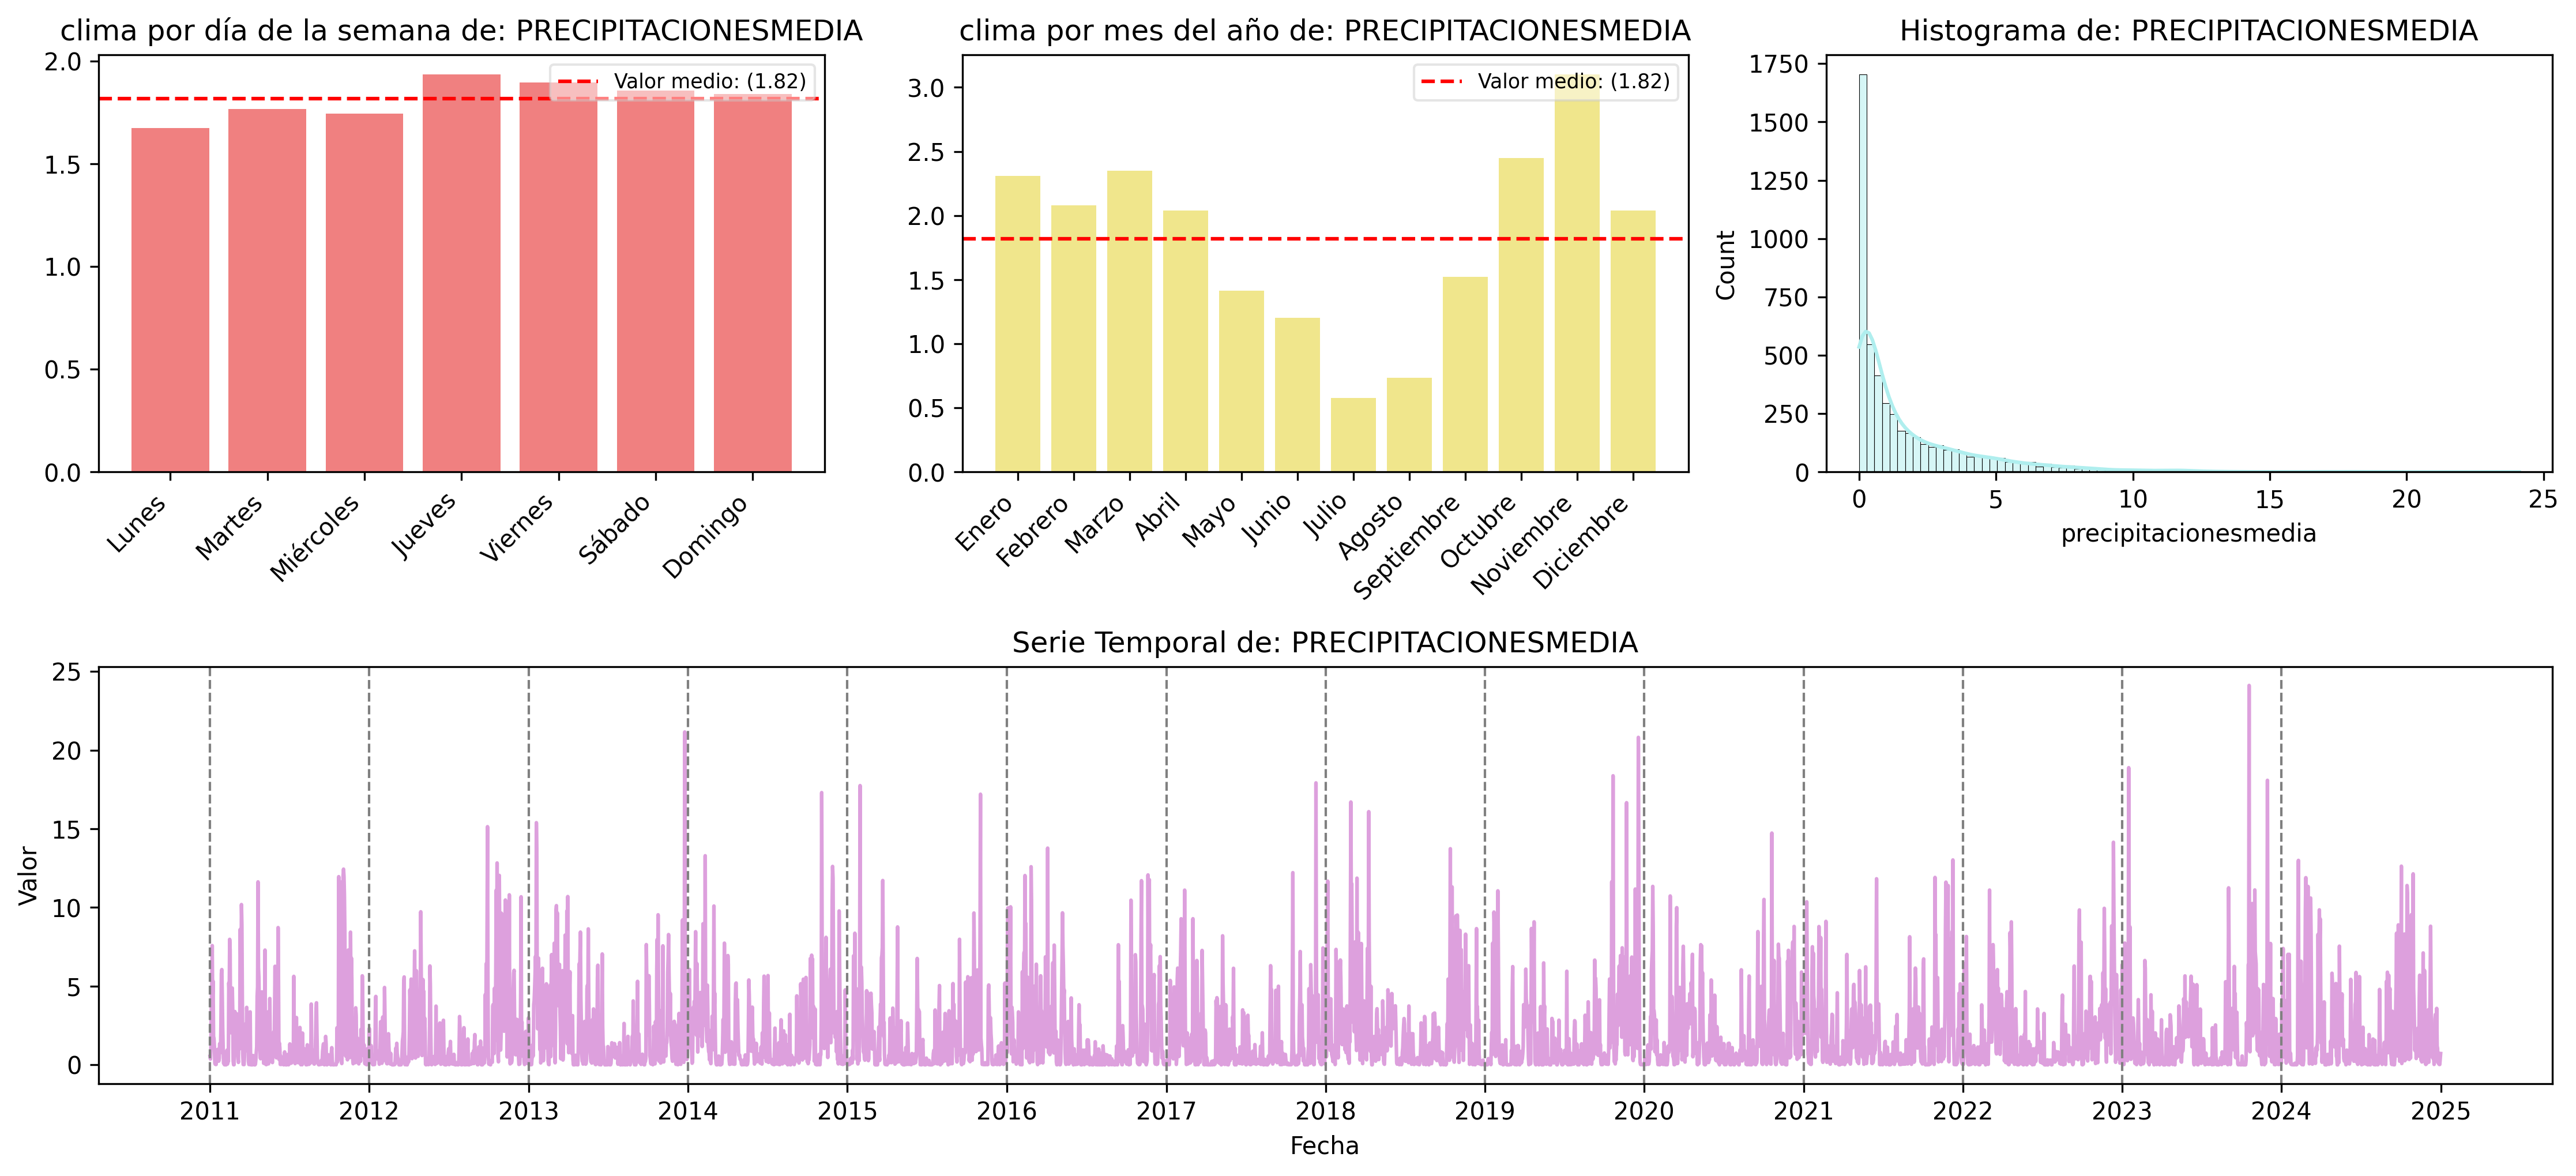

In [16]:
generarGraficasDistribucion_2filas_gen(dataframeclimatologia,'fecha','Mes','DiaSemana','precipitacionesmedia')

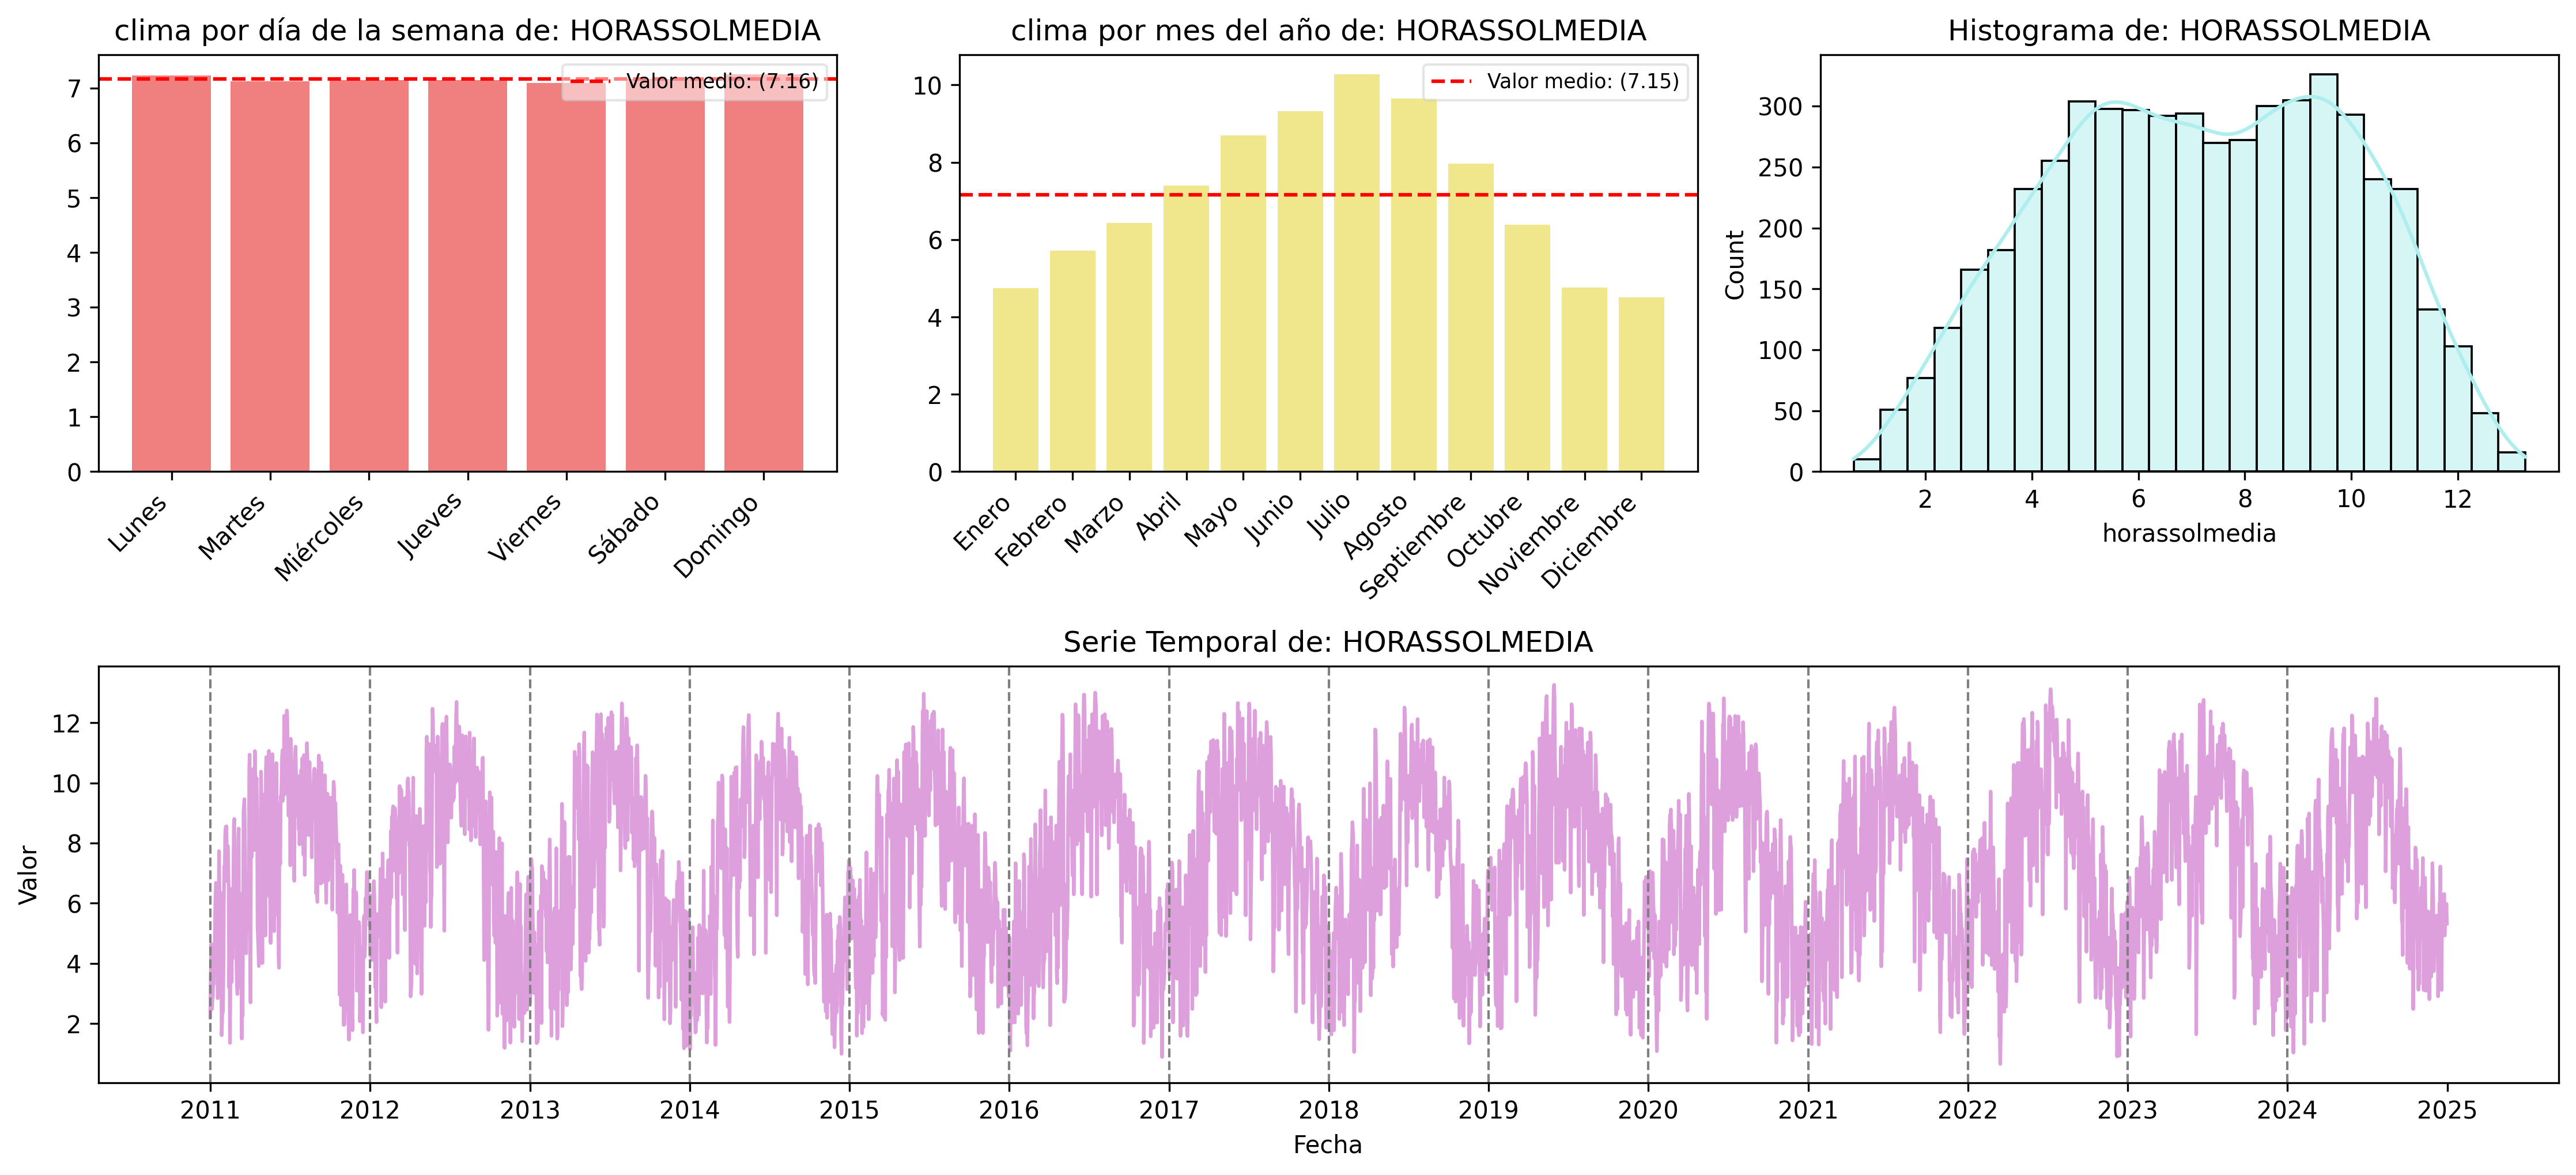

In [17]:
generarGraficasDistribucion_2filas_gen(dataframeclimatologia,'fecha','Mes','DiaSemana','horassolmedia')

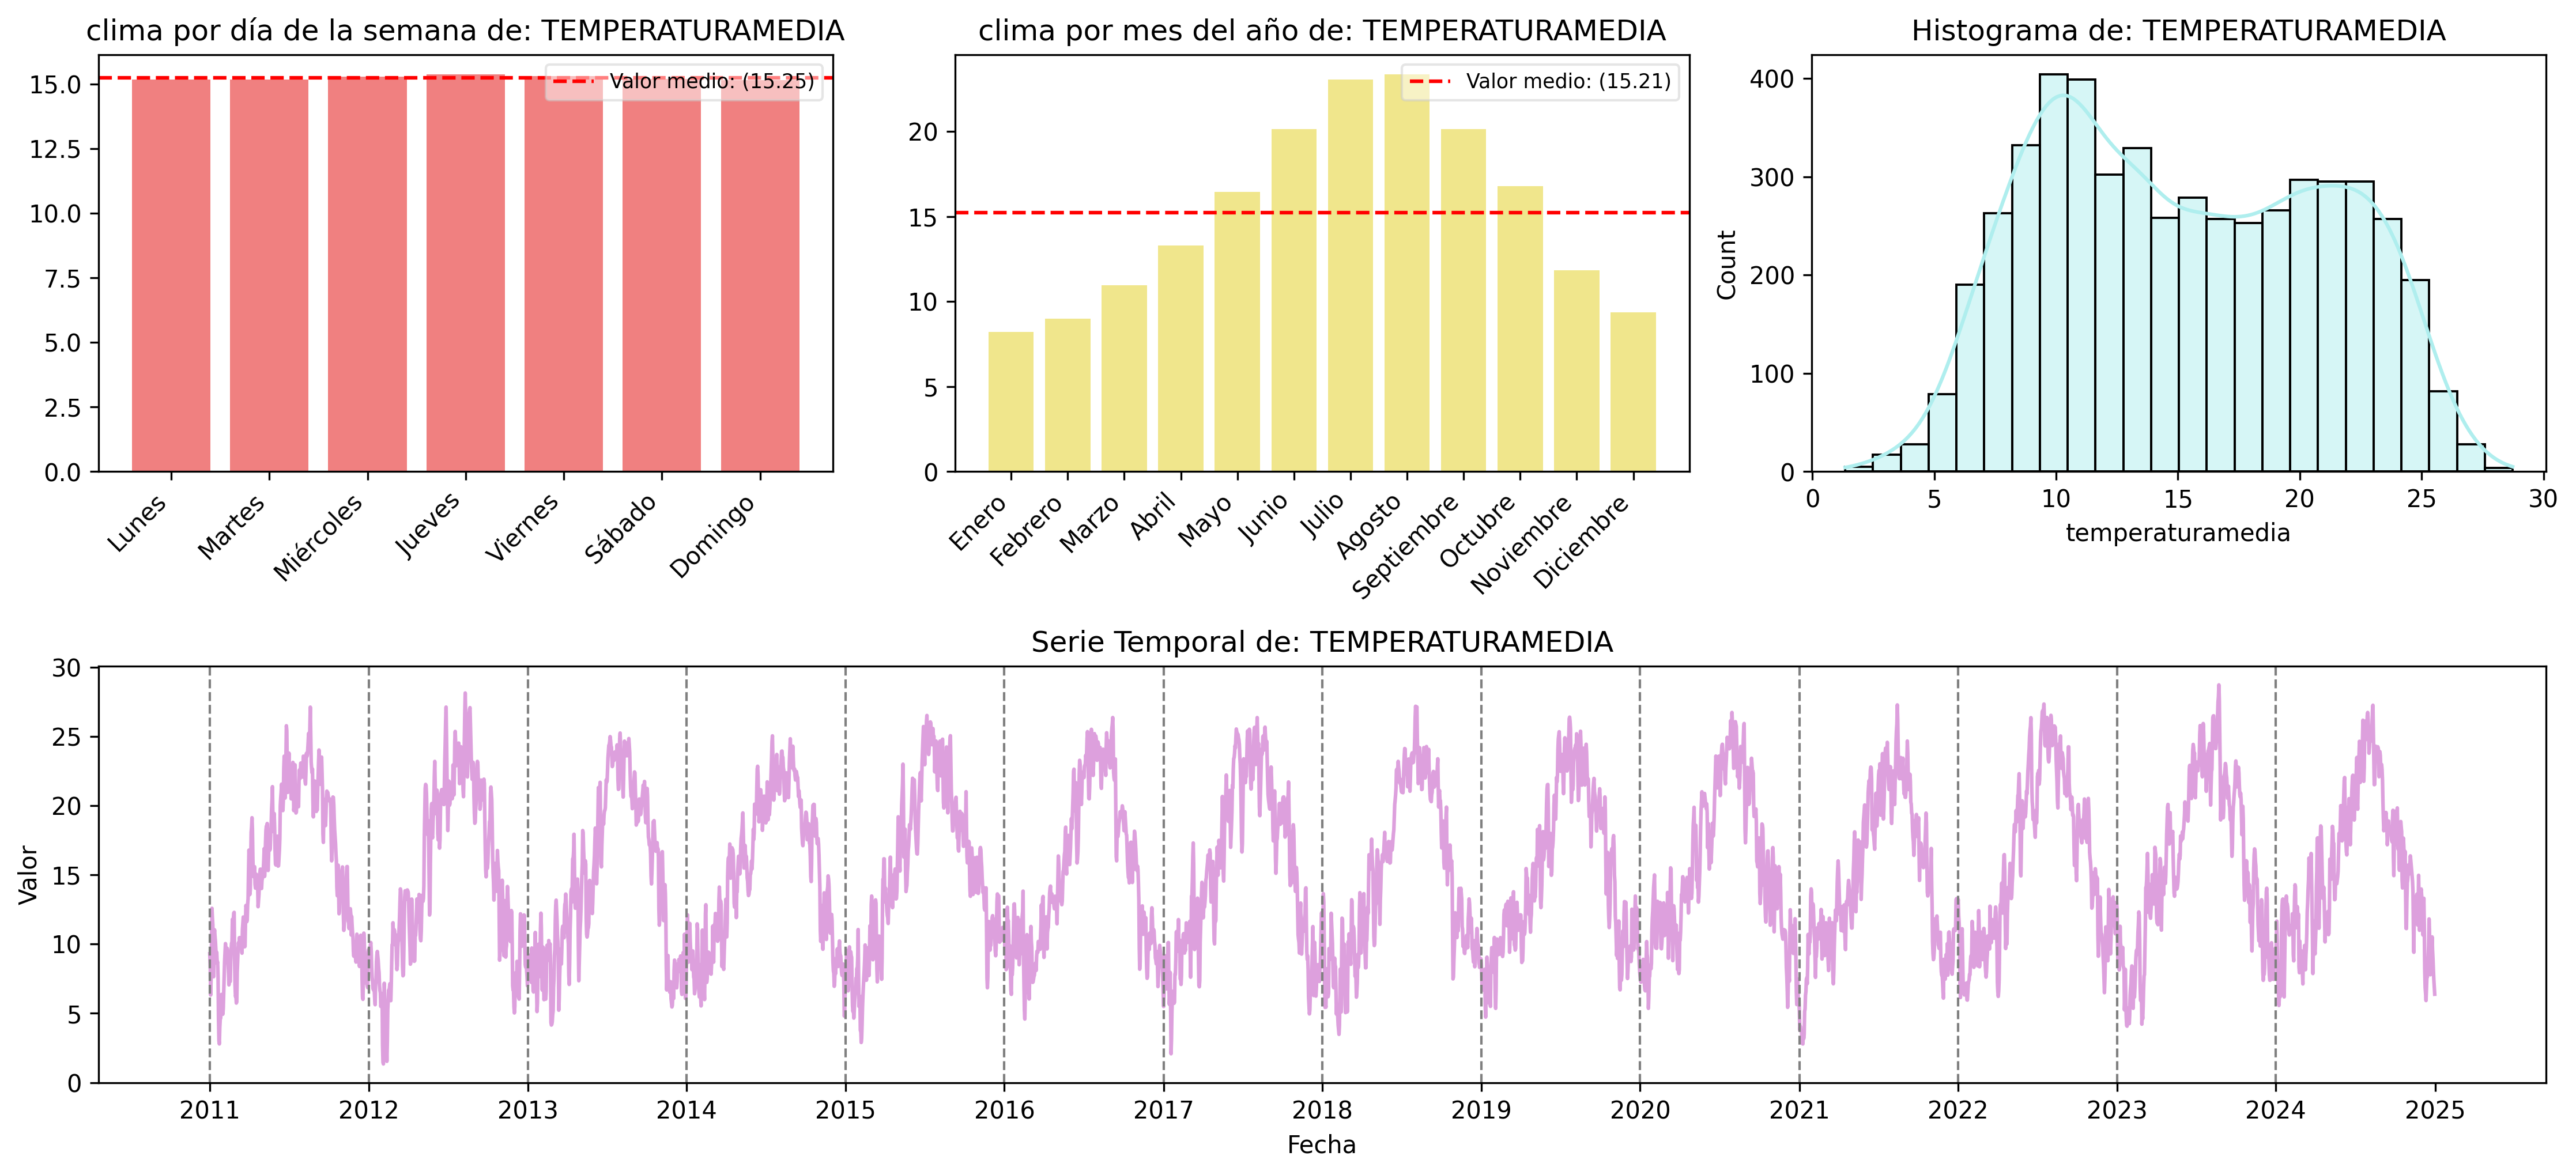

In [18]:
generarGraficasDistribucion_2filas_gen(dataframeclimatologia,'fecha','Mes','DiaSemana','temperaturamedia')

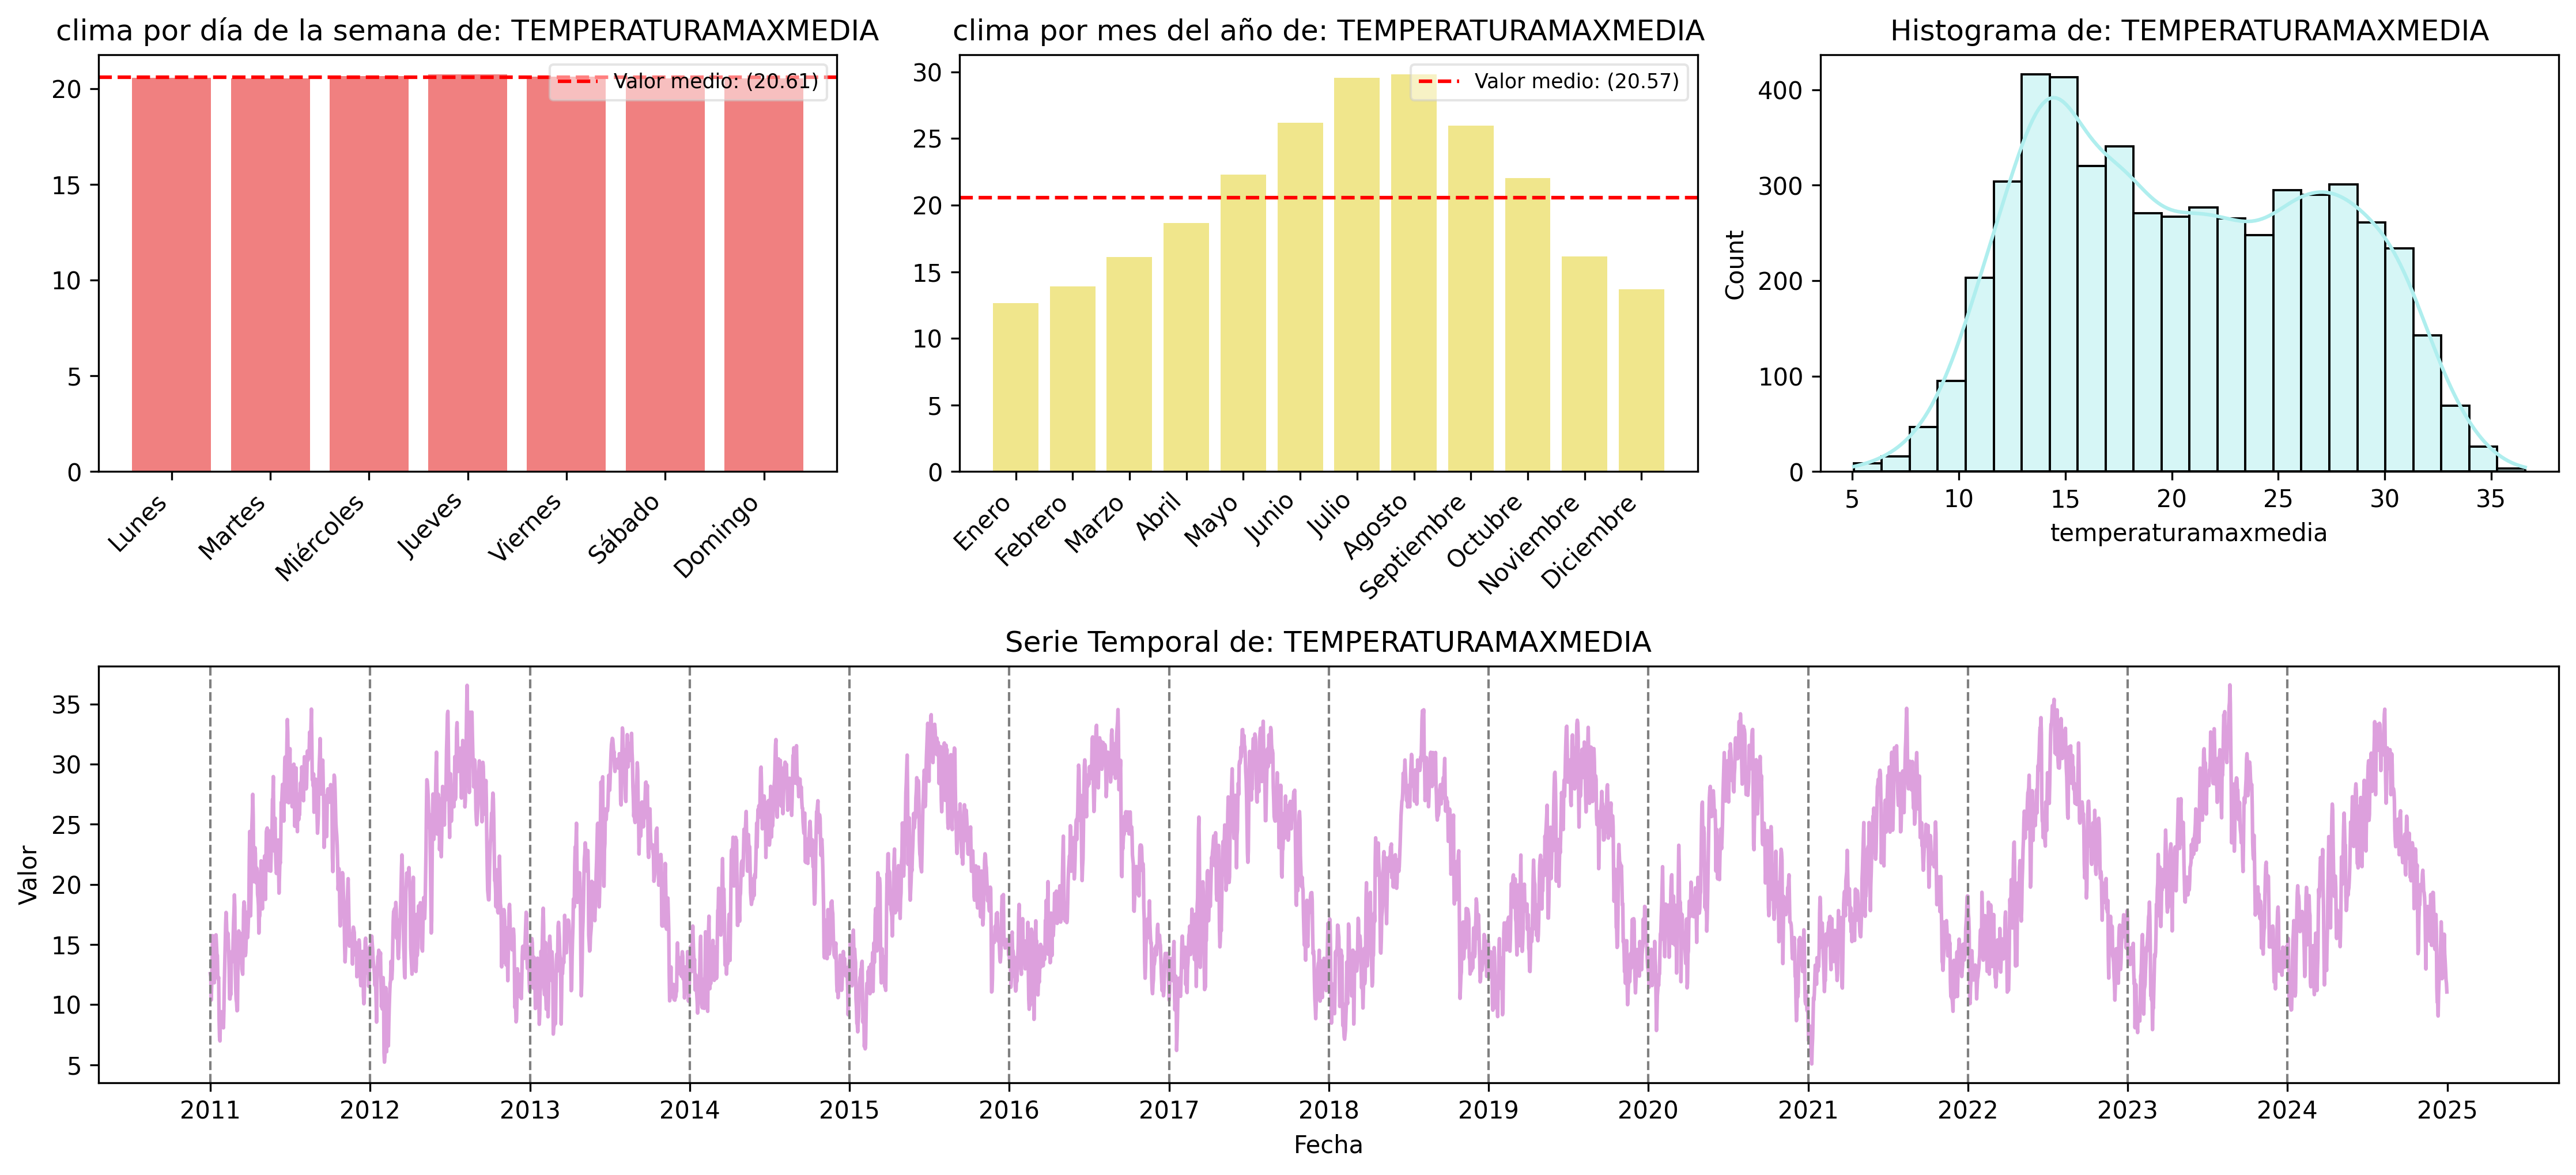

In [19]:
generarGraficasDistribucion_2filas_gen(dataframeclimatologia,'fecha','Mes','DiaSemana','temperaturamaxmedia')

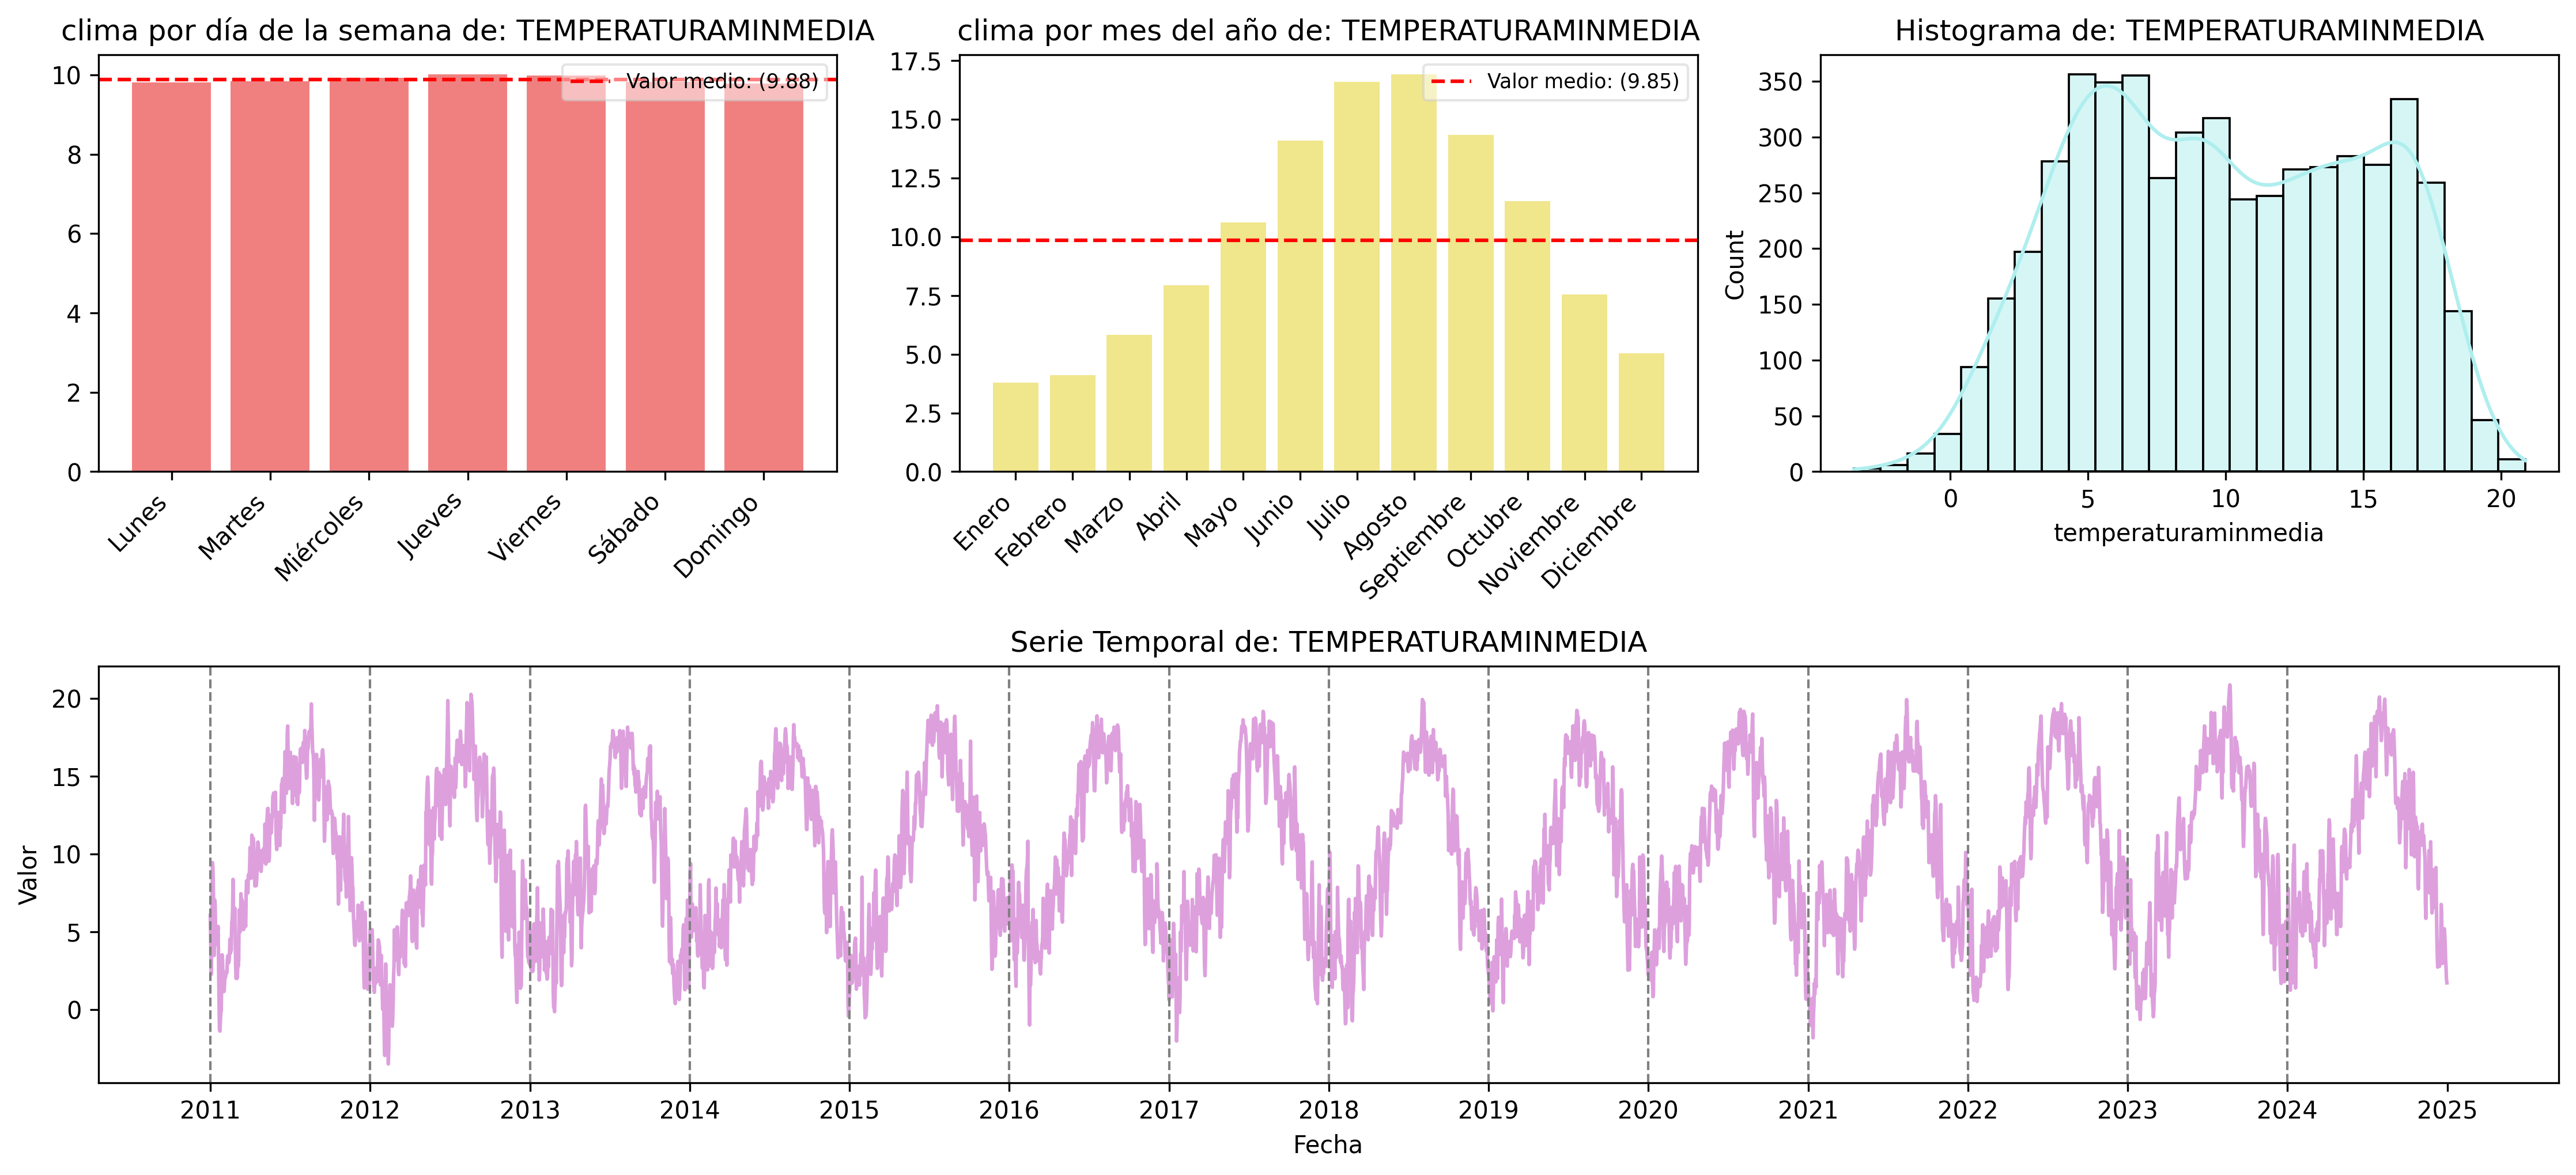

In [20]:
generarGraficasDistribucion_2filas_gen(dataframeclimatologia,'fecha','Mes','DiaSemana','temperaturaminmedia')

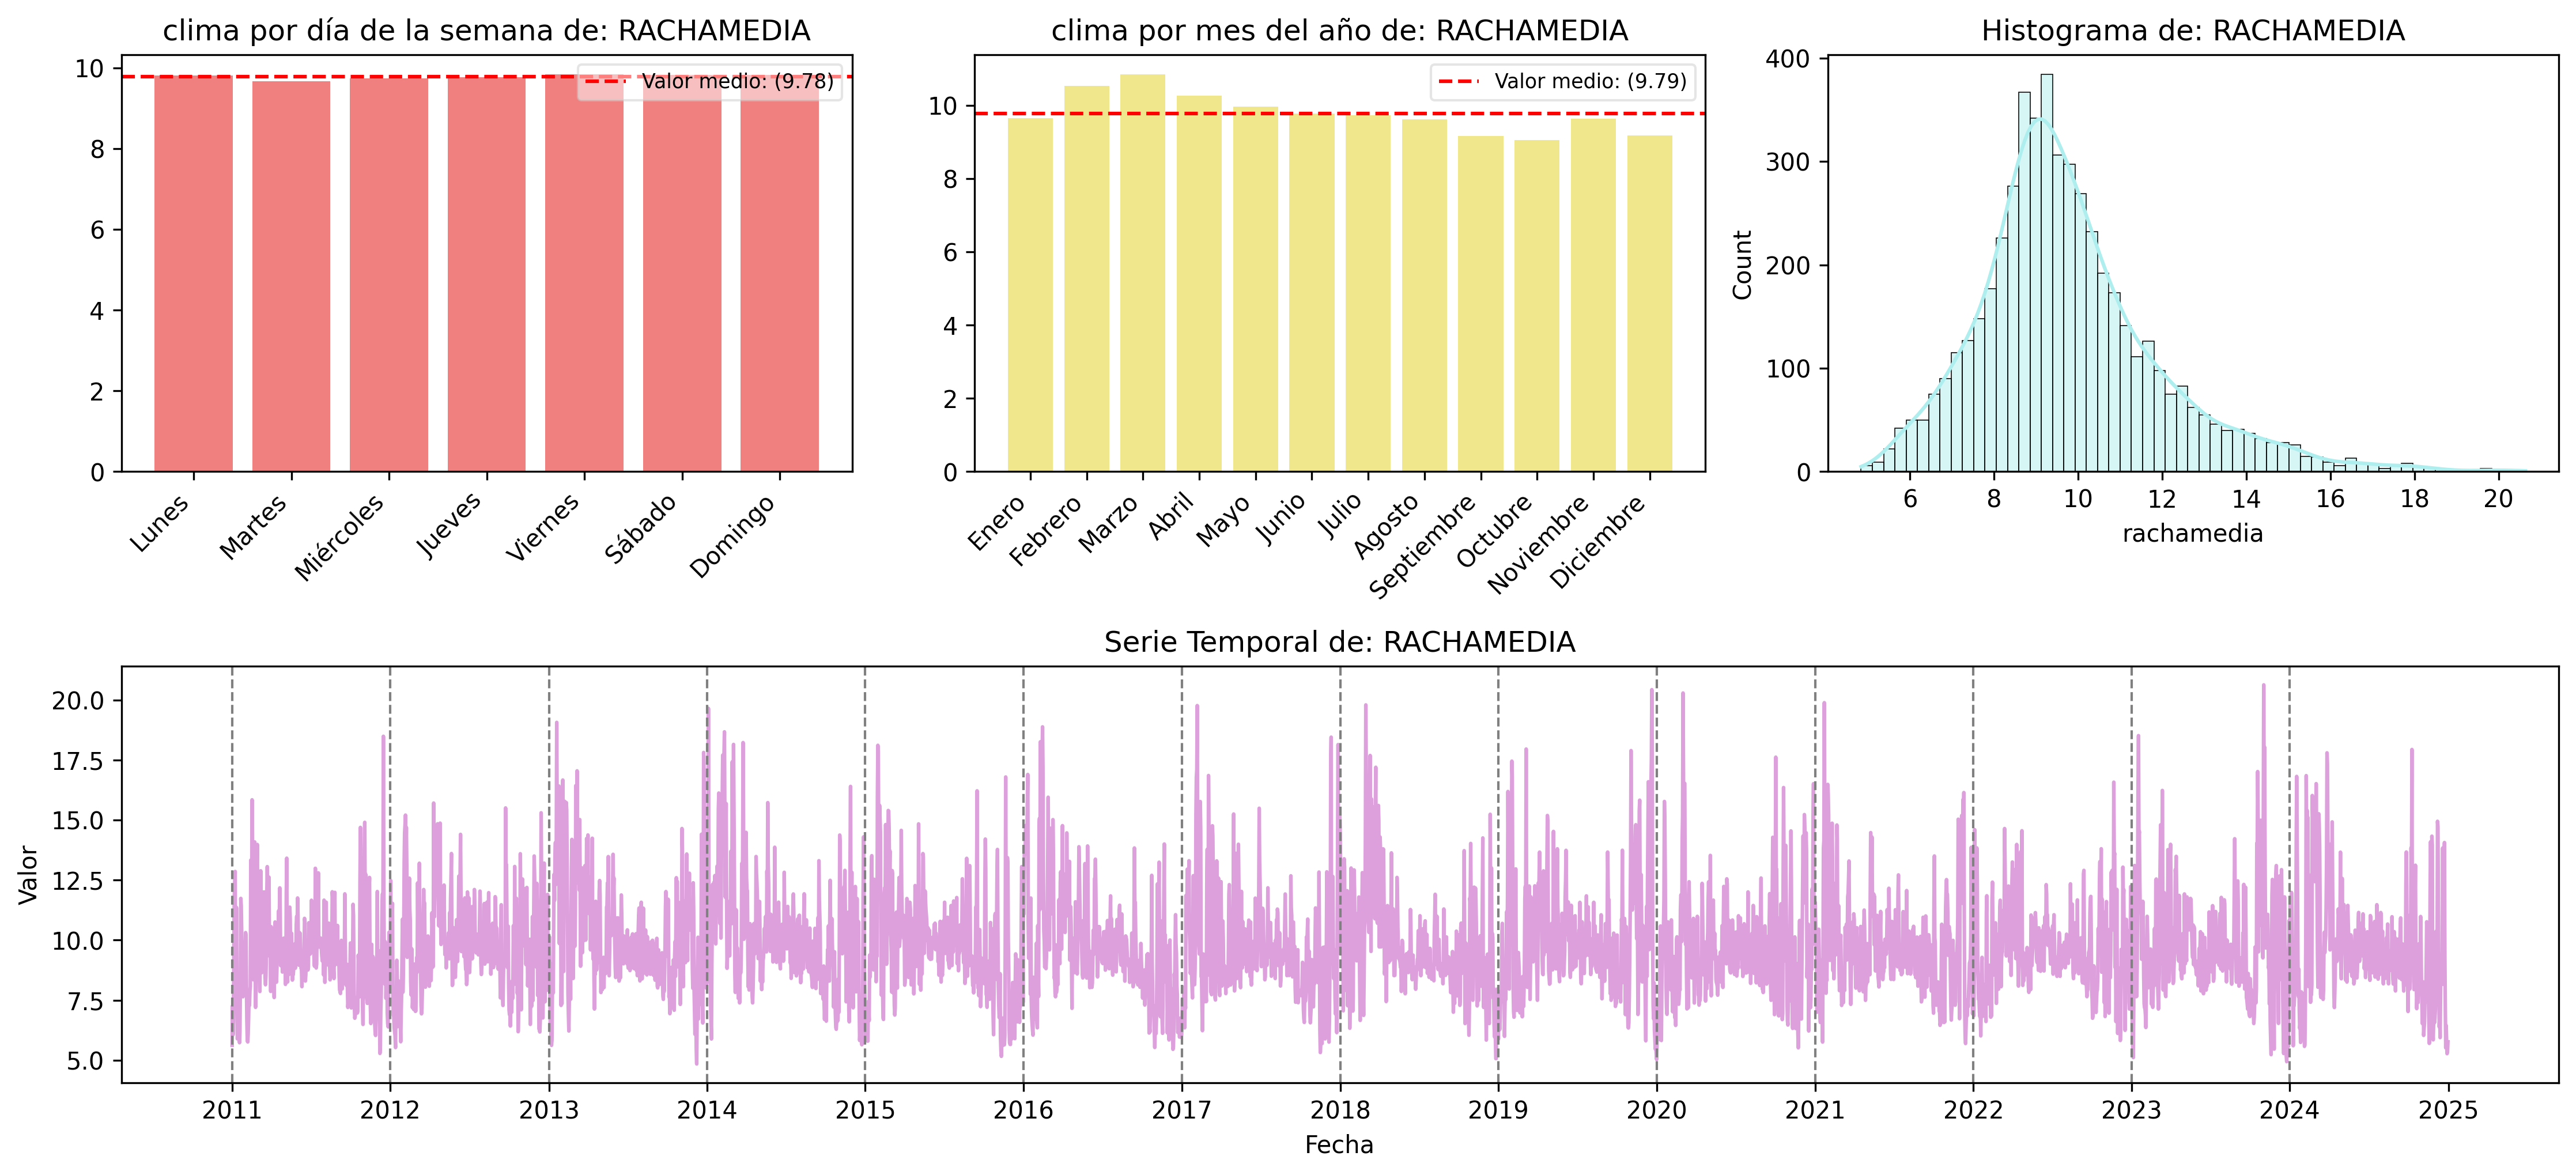

In [21]:
generarGraficasDistribucion_2filas_gen(dataframeclimatologia,'fecha','Mes','DiaSemana','rachamedia')

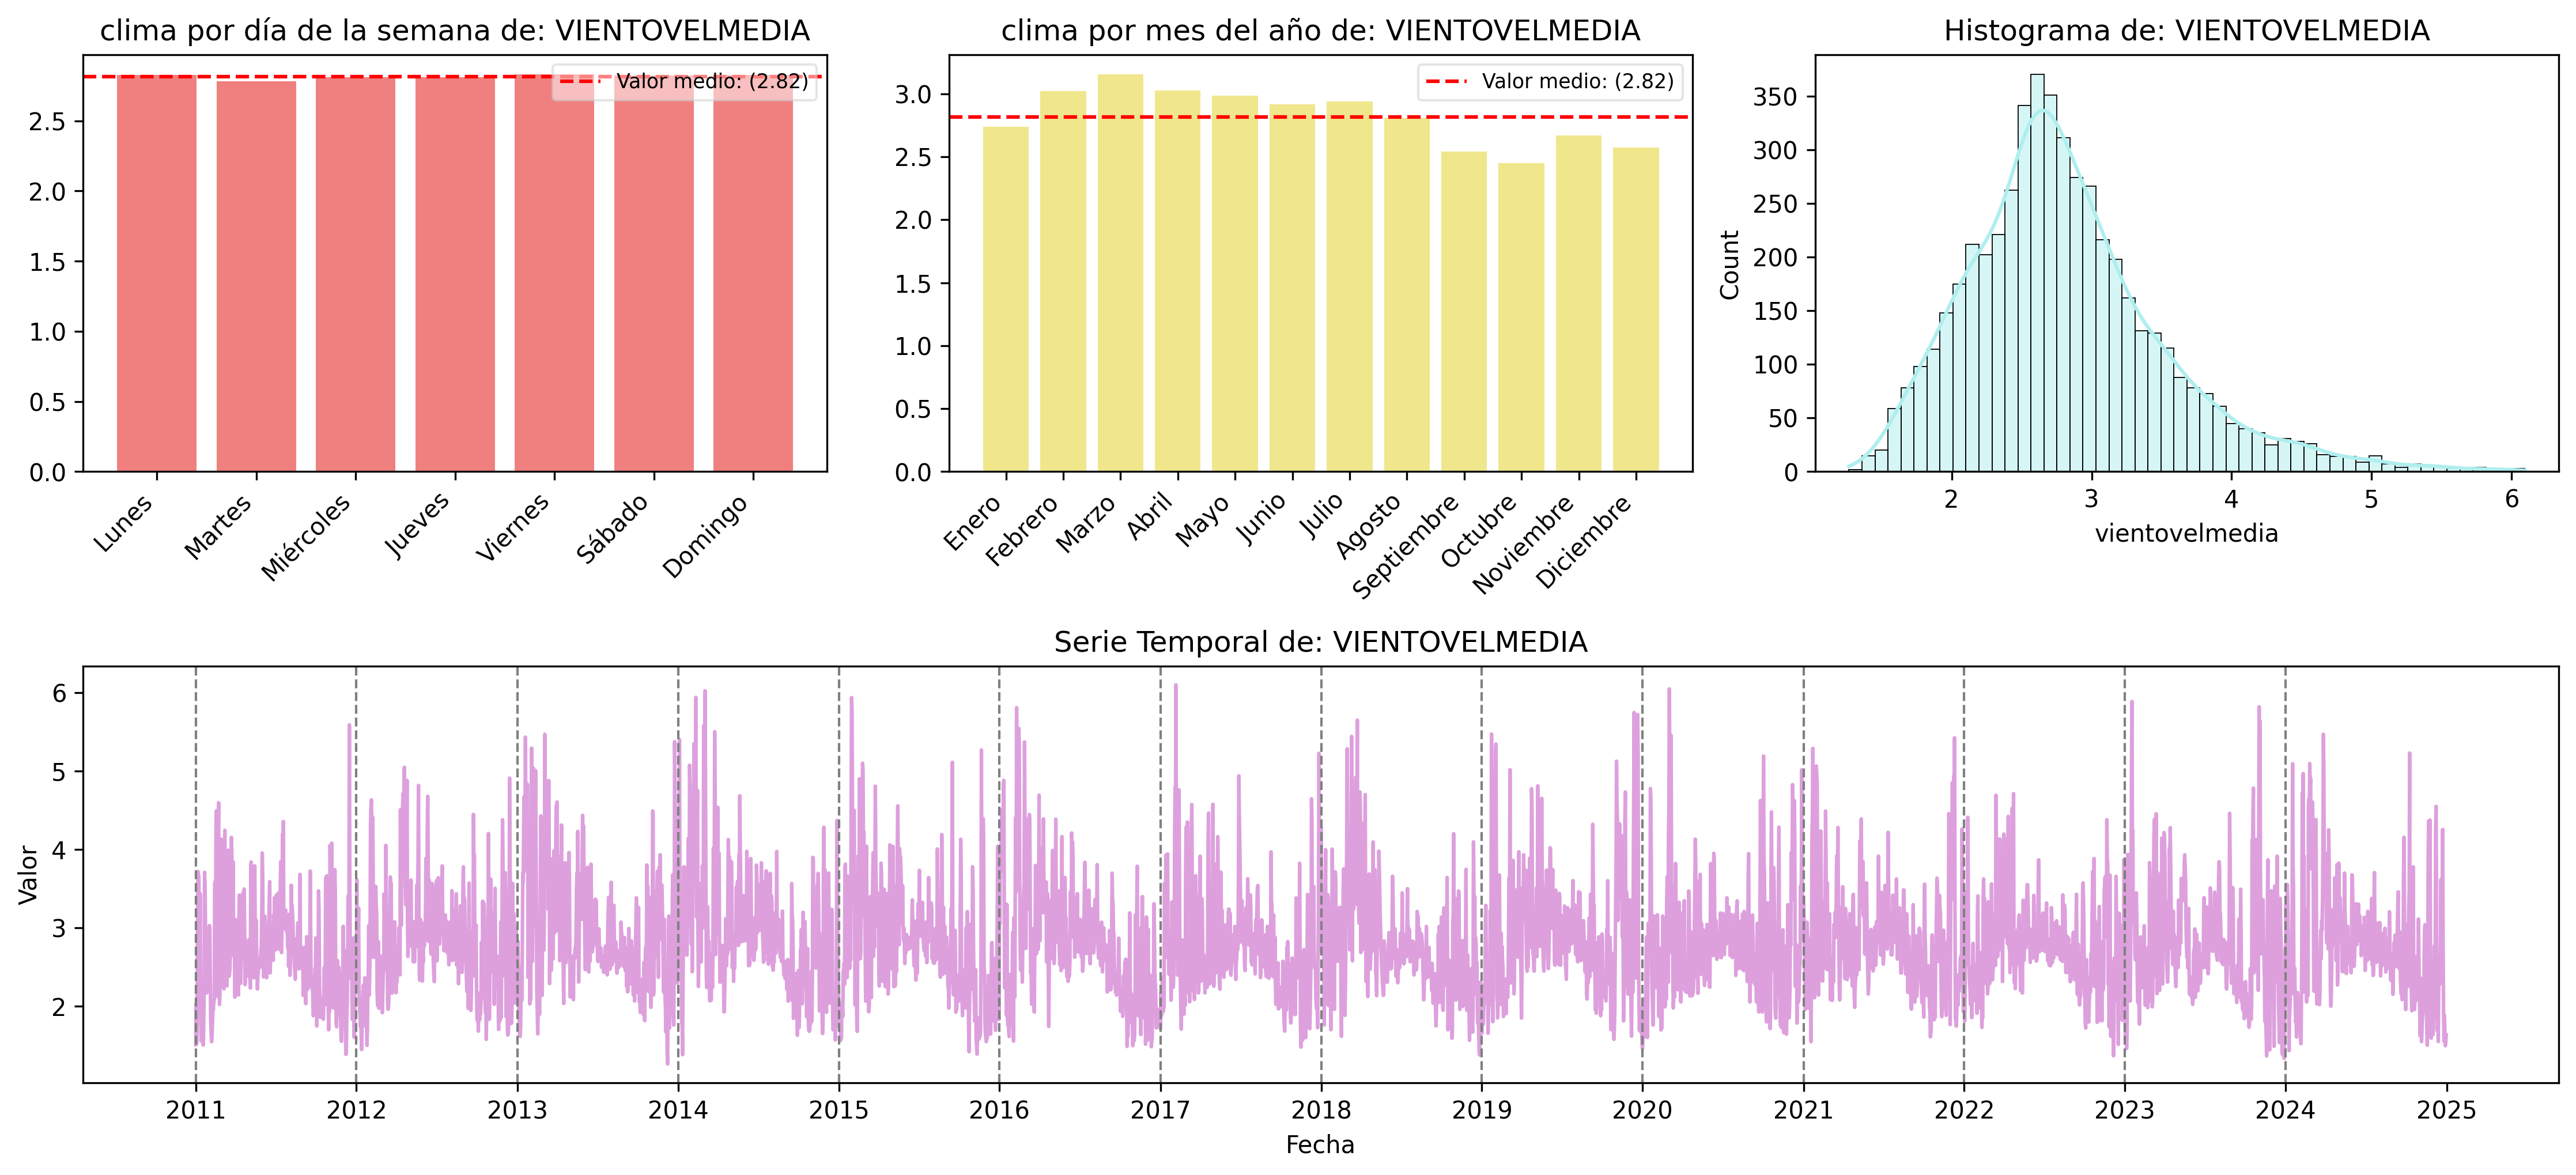

In [22]:
generarGraficasDistribucion_2filas_gen(dataframeclimatologia,'fecha','Mes','DiaSemana','vientovelmedia')

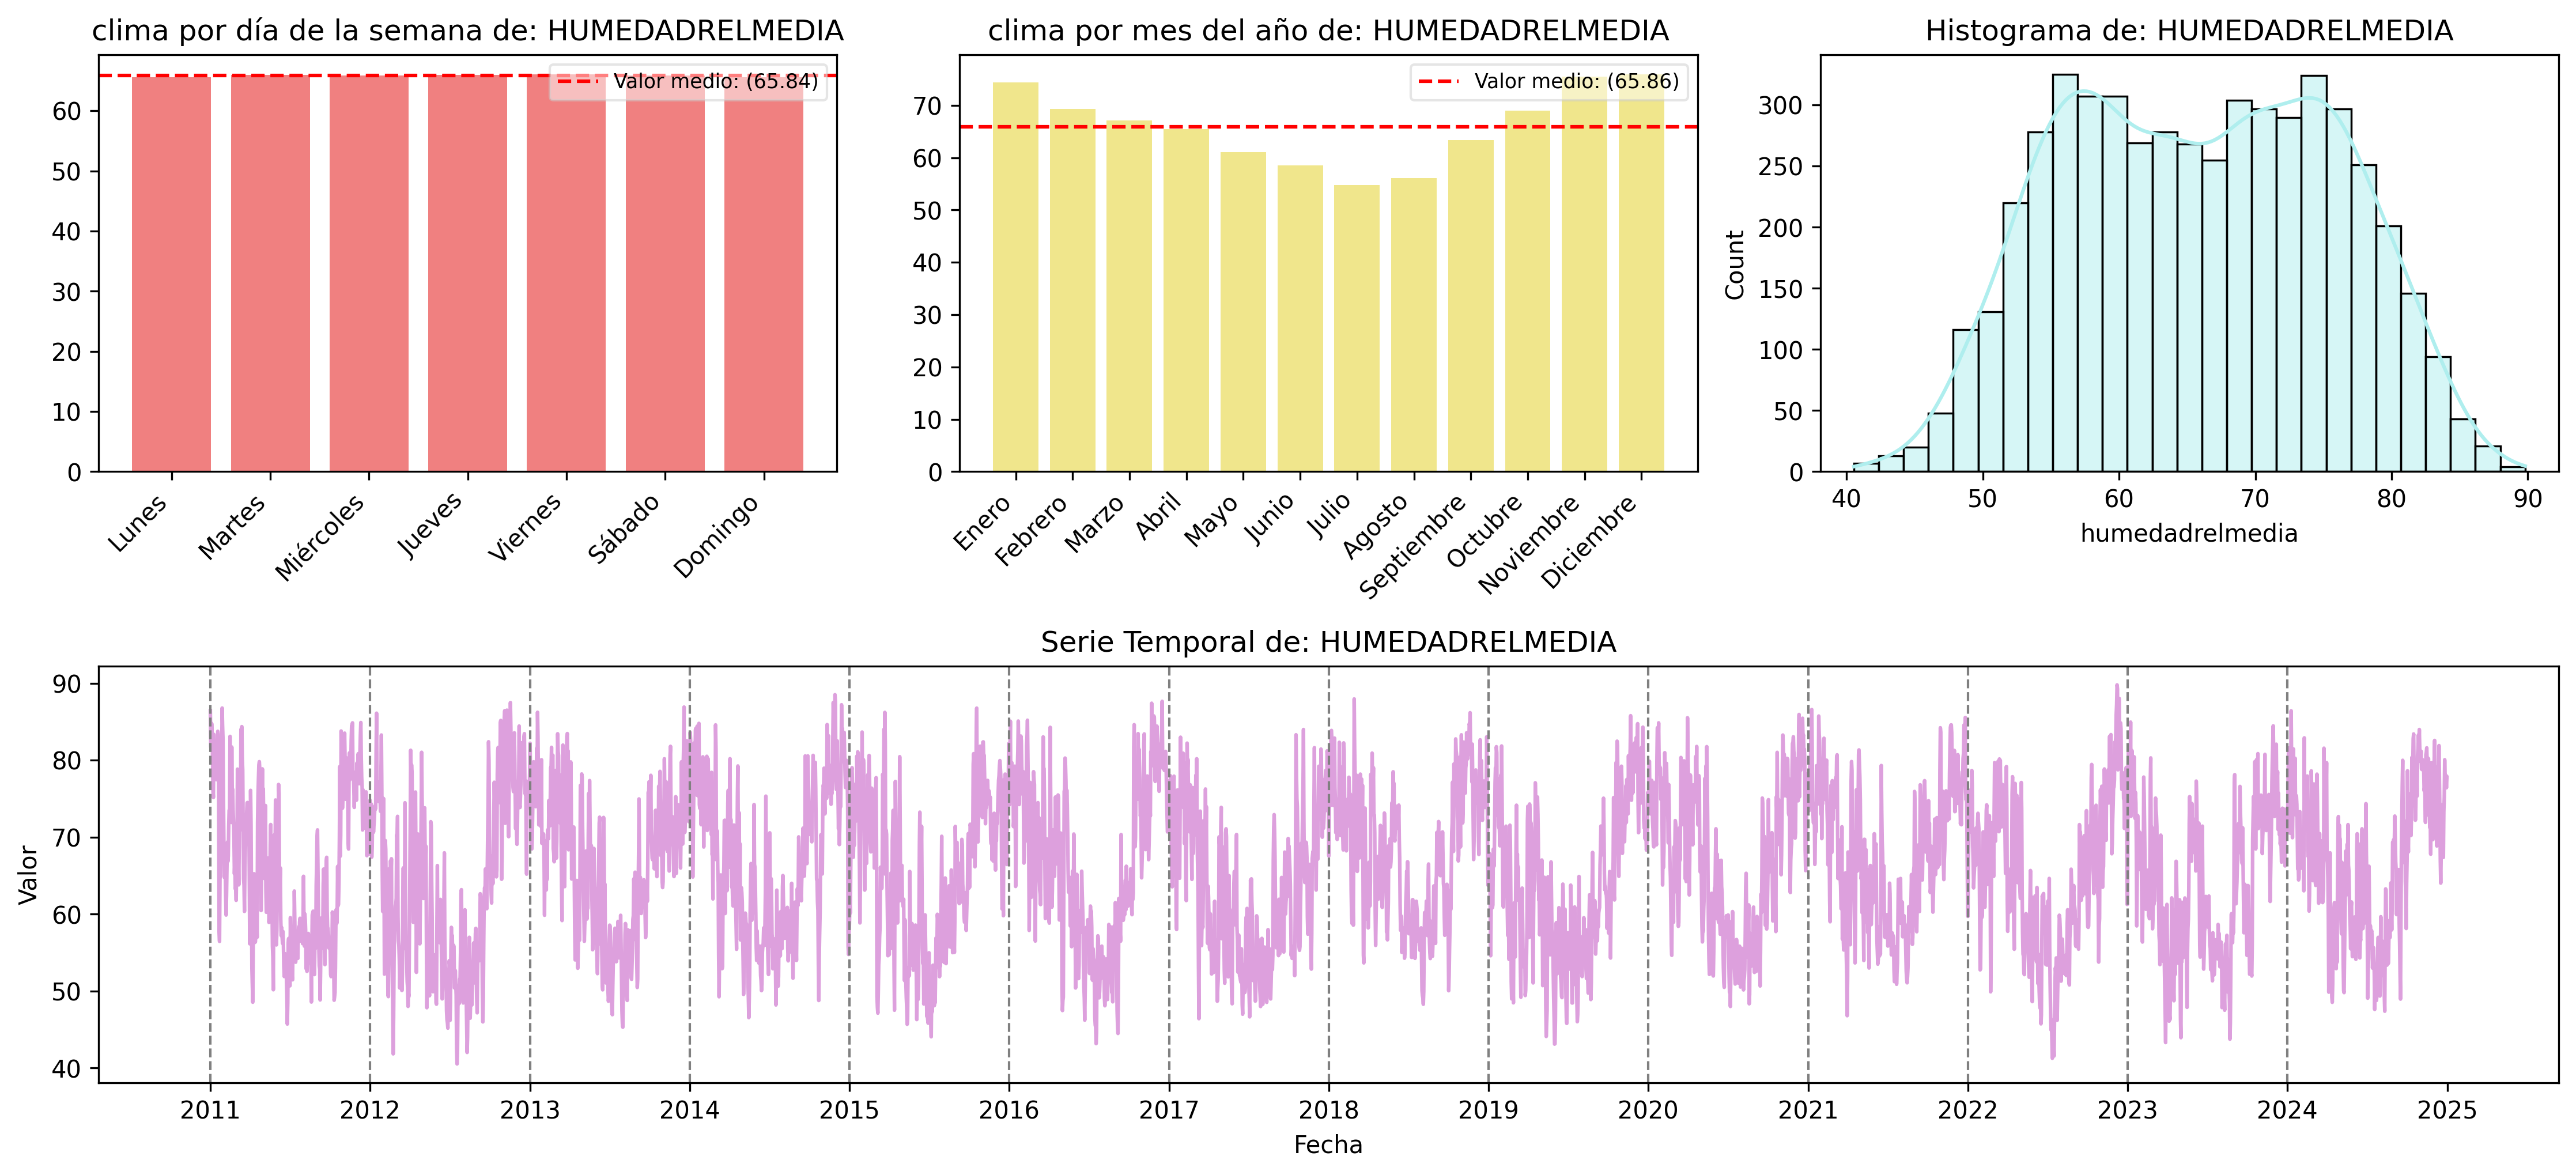

In [23]:
generarGraficasDistribucion_2filas_gen(dataframeclimatologia,'fecha','Mes','DiaSemana','humedadrelmedia')

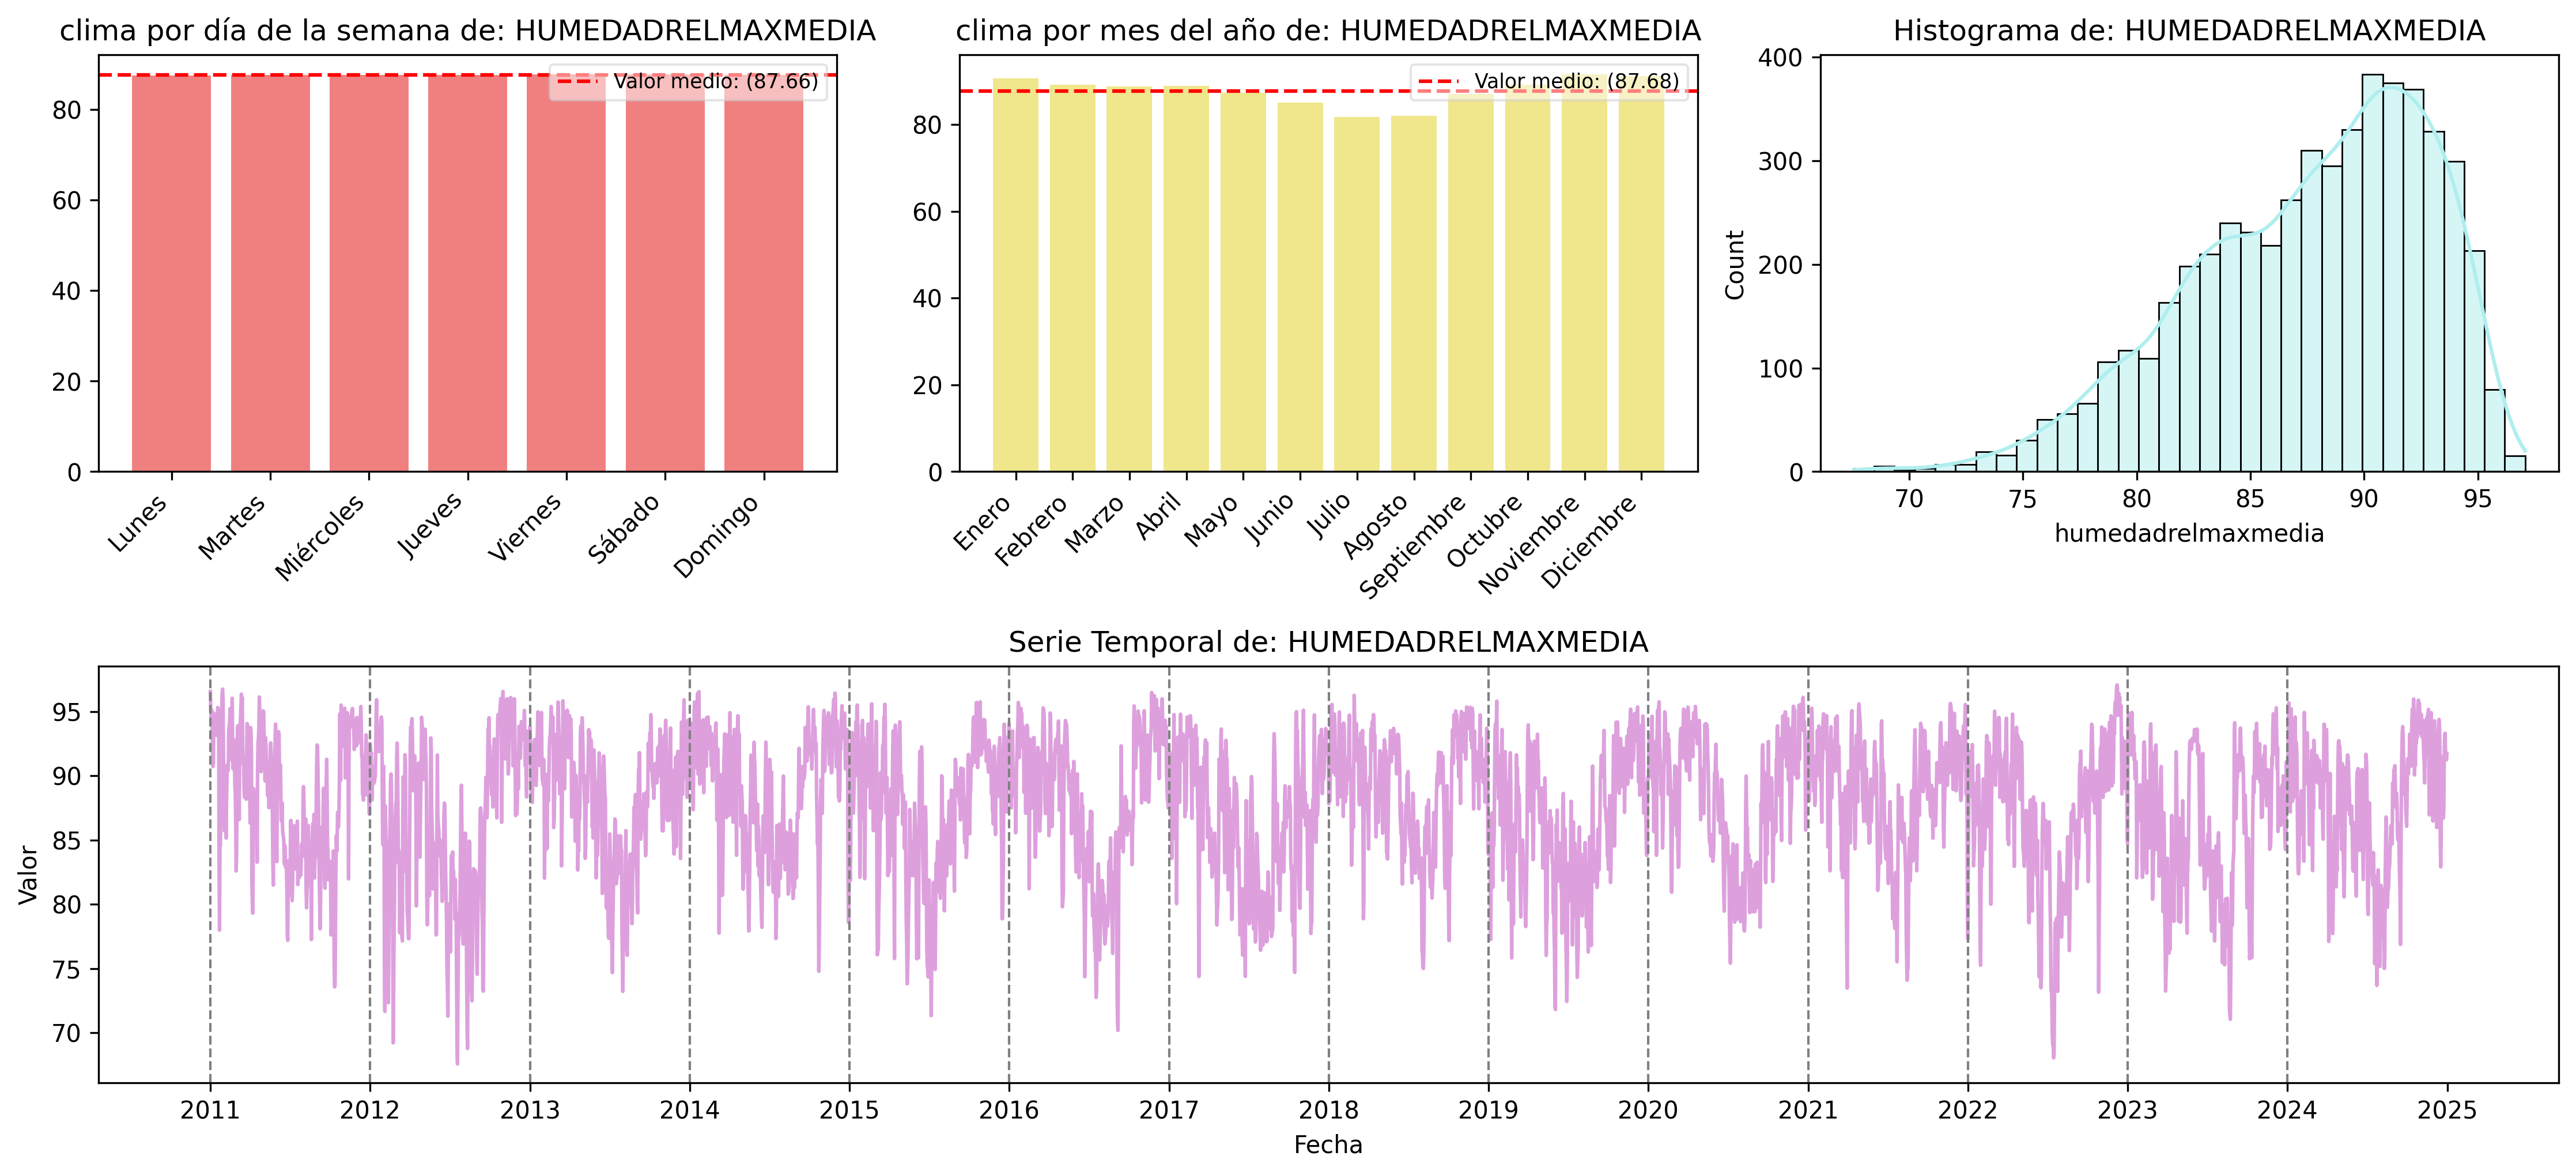

In [24]:
generarGraficasDistribucion_2filas_gen(dataframeclimatologia,'fecha','Mes','DiaSemana','humedadrelmaxmedia')

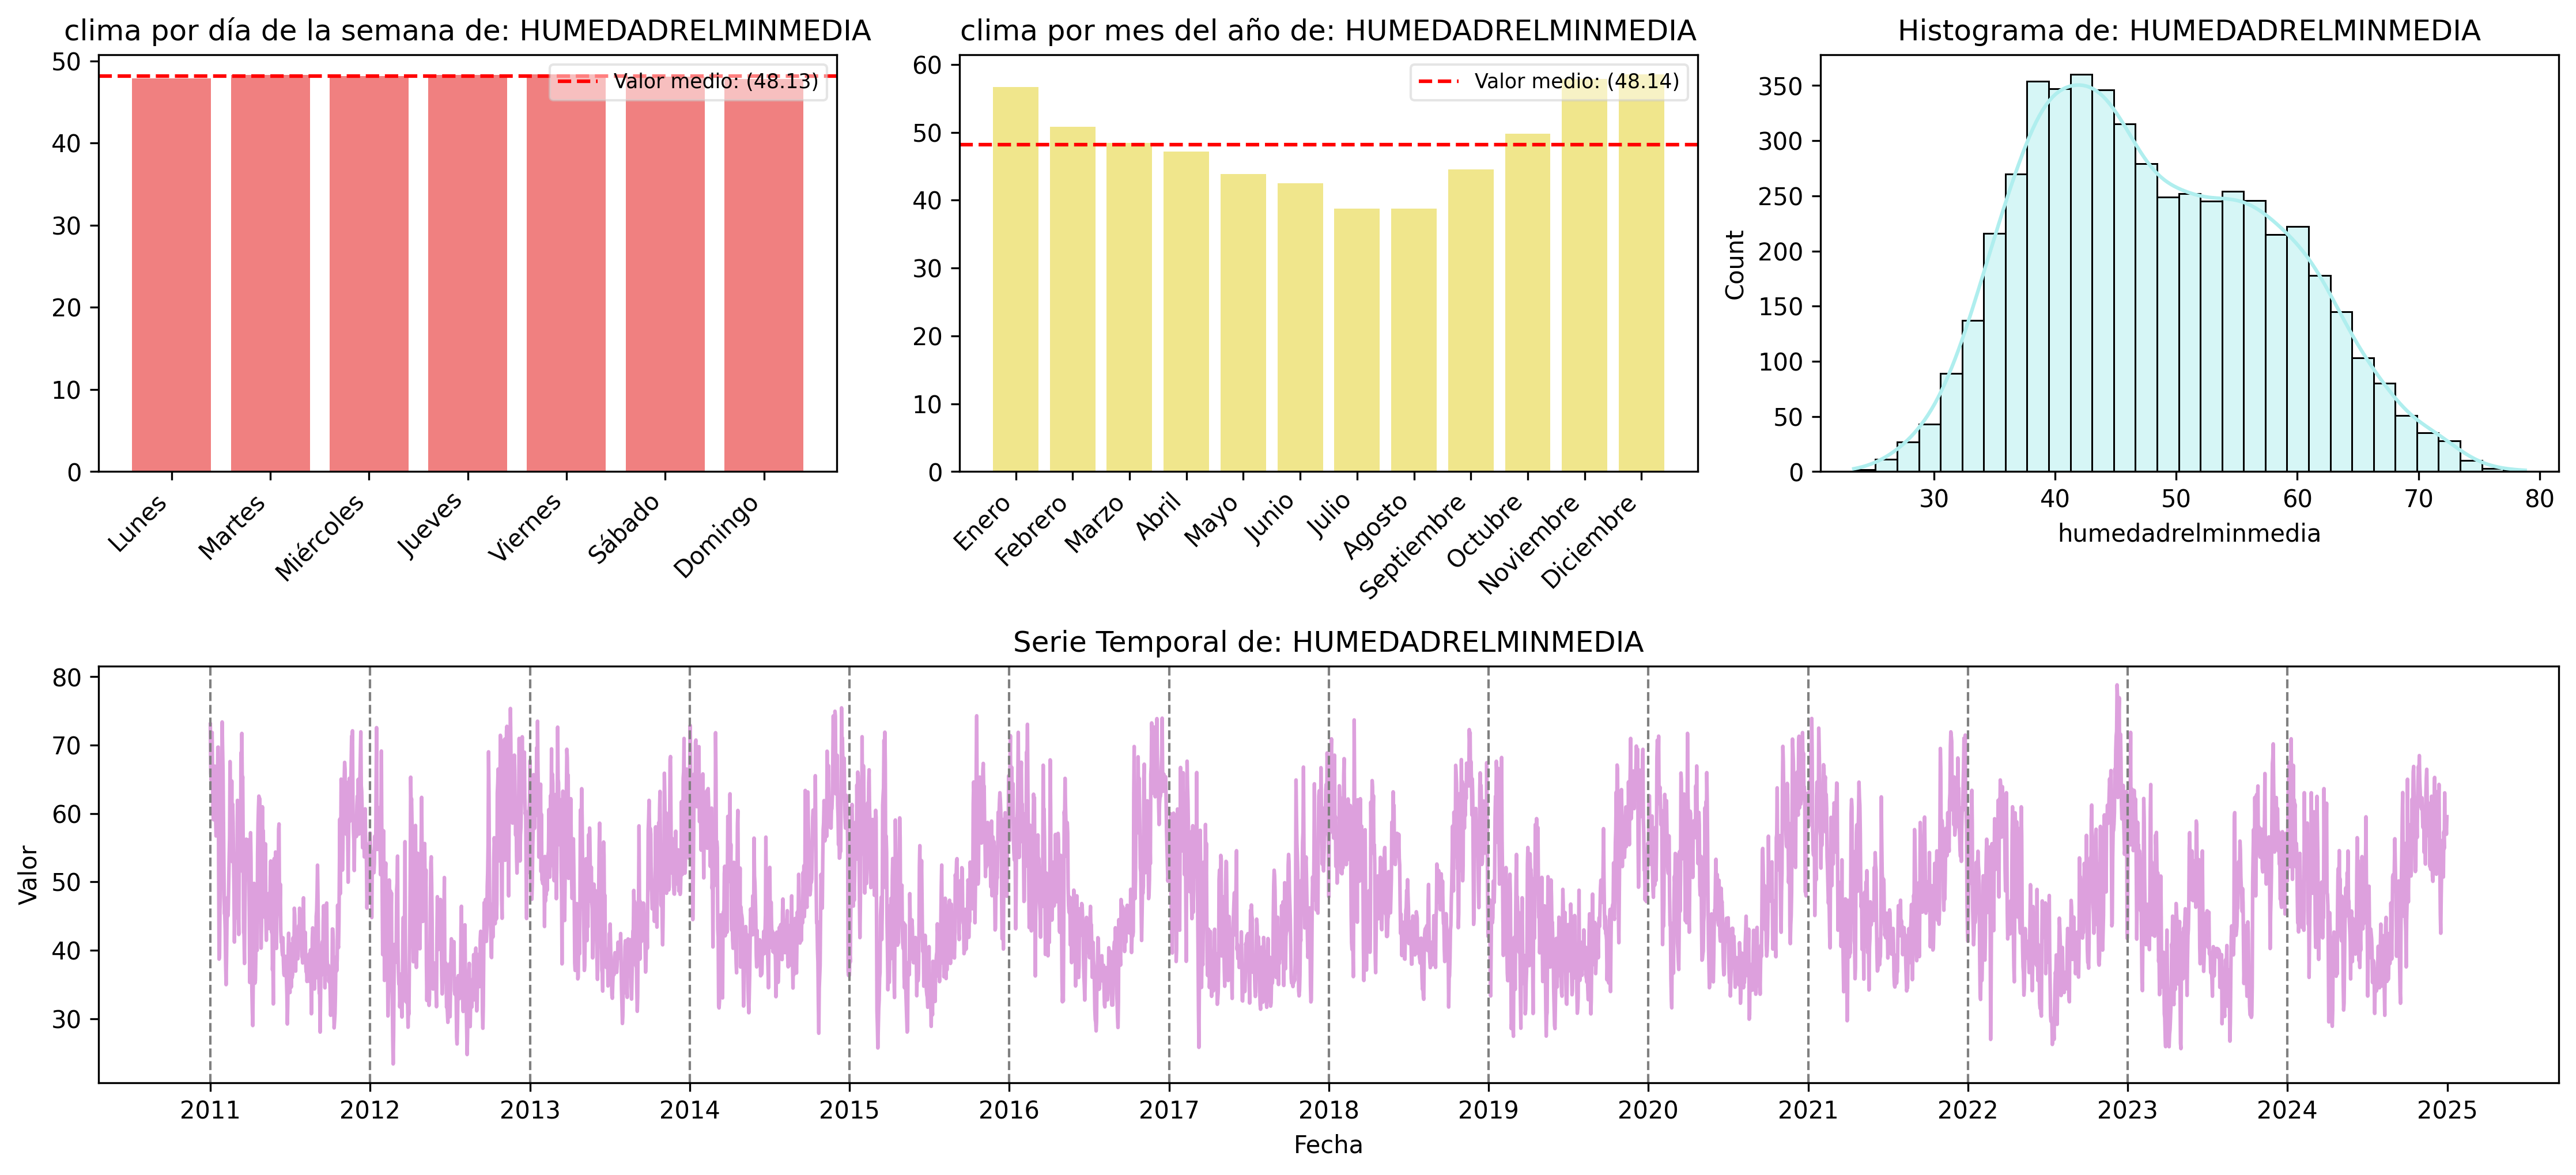

In [25]:
generarGraficasDistribucion_2filas_gen(dataframeclimatologia,'fecha','Mes','DiaSemana','humedadrelminmedia')

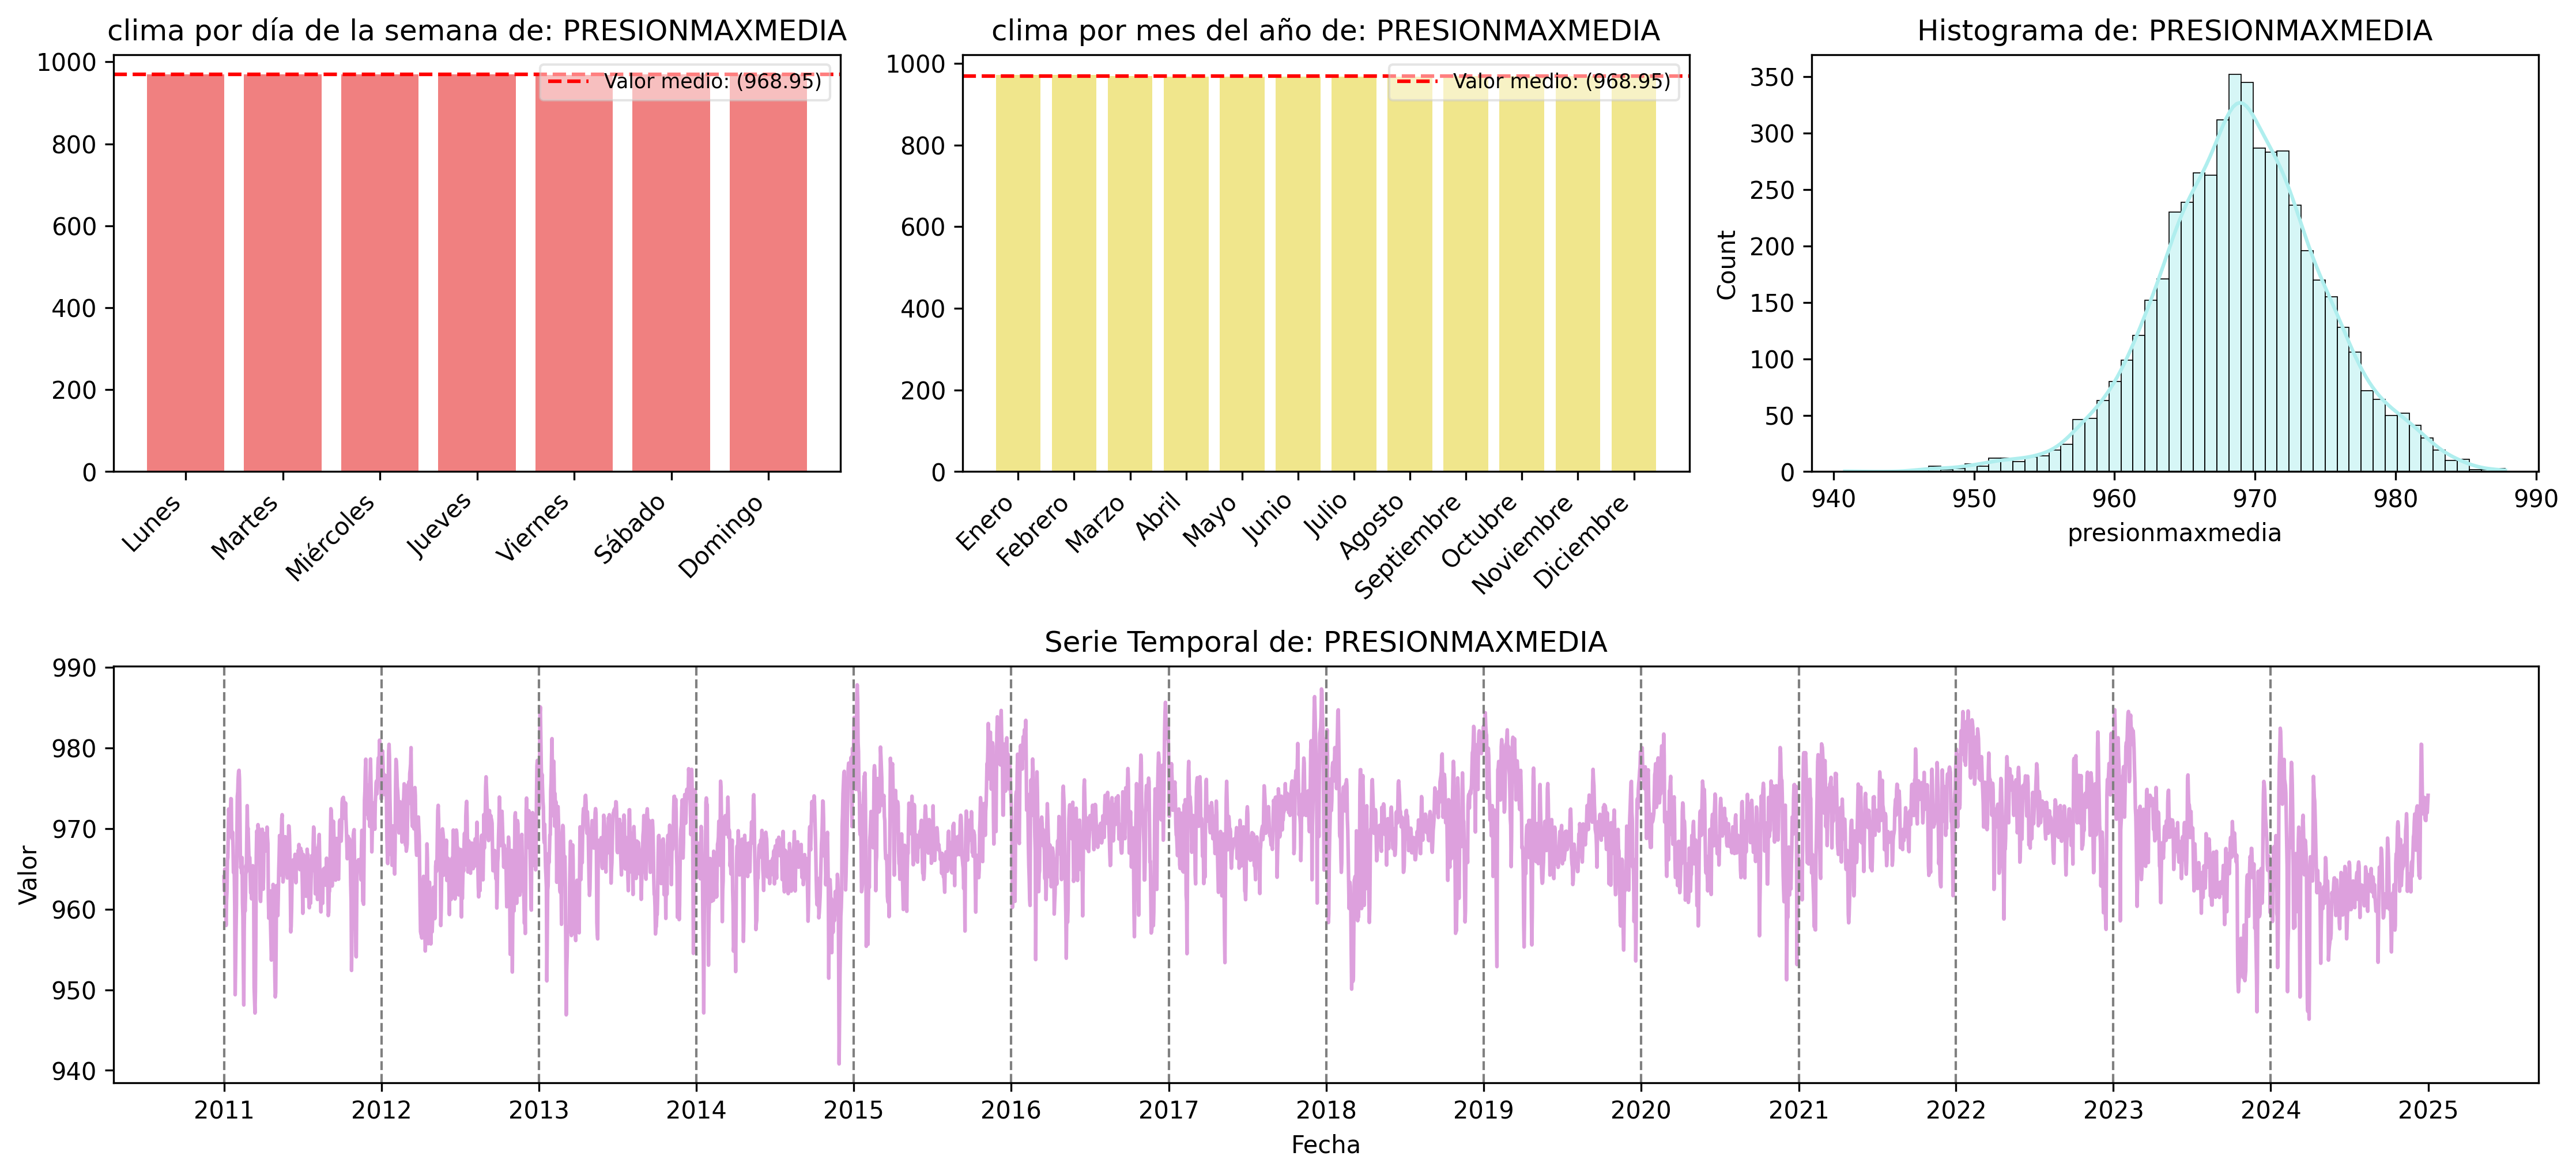

In [26]:
generarGraficasDistribucion_2filas_gen(dataframeclimatologia,'fecha','Mes','DiaSemana','presionmaxmedia')

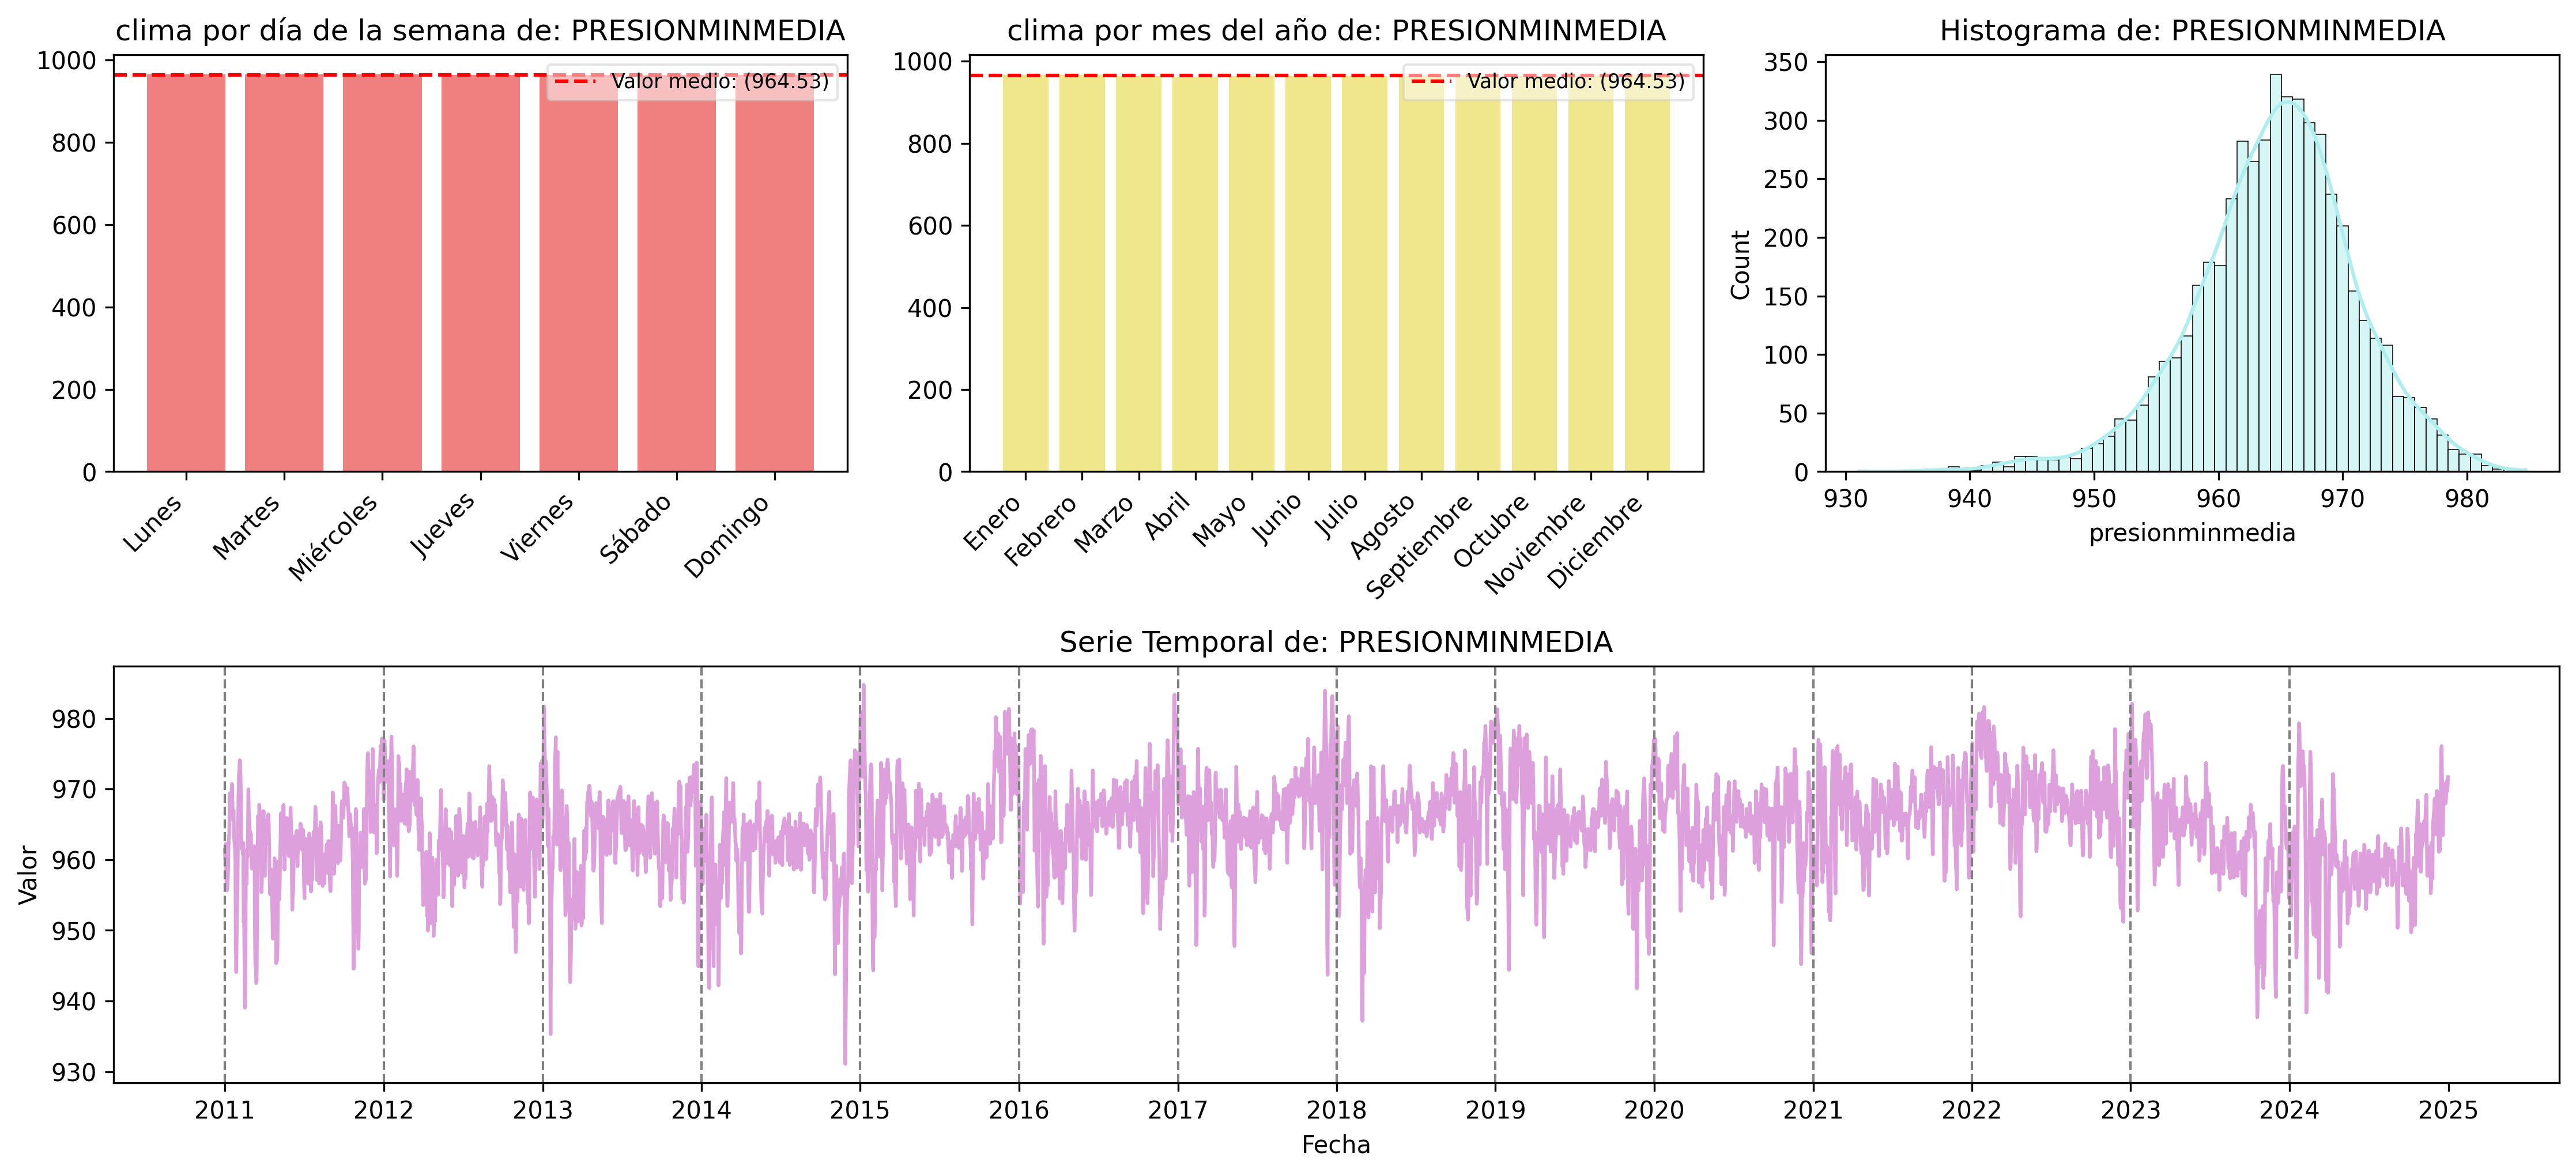

In [27]:
generarGraficasDistribucion_2filas_gen(dataframeclimatologia,'fecha','Mes','DiaSemana','presionminmedia')

Con esto damos por finalizada la parte del análisis de los datos de emisiones